<b>NOTES FOR THE VIEWER AS OF 3:47 AM NOV 26</b>

<blockquote> 
    
    1. Need to explore more features, possibly within csv file or from outside sources like gdp or 3rd world country tagging etc.
    2. 11.8K average MAE as of now
    3. Tried imputing values based on median or mode depending on dtype of feature
    4. Tried isolation forest as suggested by basti, not sure how to tune it tho, just used arbitrary params.
</blockquote> 

<b>NOTES FOR THE VIEWER AS OF 3:47 AM NOV 27</b>

<blockquote> 
    
    1. Need to explore more features, possibly within csv file or from outside sources like gdp or 3rd world country tagging etc.
    2. 8K average MAE as of now using GBM
</blockquote> 

<b>NOTES FOR THE VIEWER AS OF 3:47 AM NOV 29</b>

<blockquote> 
    
    1. GDP improved results but still 8k MAE of GBM
    2. tried MLP, slightly worse than GBM but still 8K, takes longer to run
</blockquote> 

# Imports

In [130]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
import seaborn as sns
import tqdm
from sklearn.impute import SimpleImputer
%matplotlib inline

import time
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.model_selection import KFold, StratifiedKFold
from tqdm.notebook import tqdm_notebook
from collections import Counter
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score

from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from sklearn.linear_model import Lasso
import shap
import optuna
from sklearn.metrics import median_absolute_error
import re
import os

In [131]:
os.path.abspath('')
# os.path.isfile('survey_results_public.csv')

'C:\\Users\\JG\\jupyter directory\\AIM\\TERM3\\ML2\\group project\\stackoverflow_salary\\nov_26'

# Loading Data

In [132]:
df_raw = pd.read_csv('C:\\Users\\JG\\jupyter directory\\AIM\\TERM3\\ML2\\group project\\stackoverflow_salary\survey_results_public.csv')
df_raw.isna().sum()

ResponseId                          0
MainBranch                          0
Employment                        116
Country                             0
US_State                        68519
UK_Country                      79021
EdLevel                           313
Age1stCode                        196
LearnCode                         476
YearsCode                        1798
YearsCodePro                    22223
DevType                         16955
OrgSize                         22713
Currency                        22359
CompTotal                       36256
CompFreq                        31289
LanguageHaveWorkedWith           1082
LanguageWantToWorkWith           6618
DatabaseHaveWorkedWith          13893
DatabaseWantToWorkWith          25140
PlatformHaveWorkedWith          31304
PlatformWantToWorkWith          41820
WebframeHaveWorkedWith          21732
WebframeWantToWorkWith          31344
MiscTechHaveWorkedWith          36384
MiscTechWantToWorkWith          45418
ToolsTechHav

In [133]:
df_raw.columns

Index(['ResponseId', 'MainBranch', 'Employment', 'Country', 'US_State',
       'UK_Country', 'EdLevel', 'Age1stCode', 'LearnCode', 'YearsCode',
       'YearsCodePro', 'DevType', 'OrgSize', 'Currency', 'CompTotal',
       'CompFreq', 'LanguageHaveWorkedWith', 'LanguageWantToWorkWith',
       'DatabaseHaveWorkedWith', 'DatabaseWantToWorkWith',
       'PlatformHaveWorkedWith', 'PlatformWantToWorkWith',
       'WebframeHaveWorkedWith', 'WebframeWantToWorkWith',
       'MiscTechHaveWorkedWith', 'MiscTechWantToWorkWith',
       'ToolsTechHaveWorkedWith', 'ToolsTechWantToWorkWith',
       'NEWCollabToolsHaveWorkedWith', 'NEWCollabToolsWantToWorkWith', 'OpSys',
       'NEWStuck', 'NEWSOSites', 'SOVisitFreq', 'SOAccount', 'SOPartFreq',
       'SOComm', 'NEWOtherComms', 'Age', 'Gender', 'Trans', 'Sexuality',
       'Ethnicity', 'Accessibility', 'MentalHealth', 'SurveyLength',
       'SurveyEase', 'ConvertedCompYearly'],
      dtype='object')

# Cleaning

## Dropping Unimportant Columns

In [134]:
cols_drop = ['US_State', 'UK_Country', 'Age1stCode', 'LearnCode', 'Currency', 
             'CompTotal', 'CompFreq', 'LanguageWantToWorkWith', 
             'DatabaseWantToWorkWith', 'PlatformWantToWorkWith', 'WebframeWantToWorkWith', 
             'WebframeHaveWorkedWith', 'MiscTechHaveWorkedWith', 'MiscTechWantToWorkWith',
             'ToolsTechHaveWorkedWith', 'ToolsTechWantToWorkWith', 'NEWCollabToolsHaveWorkedWith', 
             'NEWCollabToolsWantToWorkWith', 'NEWStuck', 'NEWSOSites', 'SOVisitFreq', 
             'SOAccount', 'SOComm', 'NEWOtherComms', 'Gender', 'Trans', 'Sexuality',
             'Ethnicity', 'Accessibility', 'MentalHealth', 'SurveyLength',
             'SurveyEase']
df_drop = df_raw.drop(columns=cols_drop, axis=0)
df_drop.head(3)

,ResponseId,MainBranch,Employment,Country,EdLevel,YearsCode,YearsCodePro,DevType,OrgSize,LanguageHaveWorkedWith,DatabaseHaveWorkedWith,PlatformHaveWorkedWith,OpSys,SOPartFreq,Age,ConvertedCompYearly
0,1,I am a developer by profession,"Independent contractor, freelancer, or self-em...",Slovakia,"Secondary school (e.g. American high school, G...",NaN,NaN,"Developer, mobile",20 to 99 employees,C++;HTML/CSS;JavaScript;Objective-C;PHP;Swift,PostgreSQL;SQLite,NaN,MacOS,A few times per month or weekly,25-34 years old,62268.0
1,2,I am a student who is learning to code,"Student, full-time",Netherlands,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",7,NaN,NaN,NaN,JavaScript;Python,PostgreSQL,NaN,Windows,Daily or almost daily,18-24 years old,NaN
2,3,"I am not primarily a developer, but I write co...","Student, full-time",Russian Federation,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",NaN,NaN,NaN,NaN,Assembly;C;Python;R;Rust,SQLite,Heroku,MacOS,Multiple times per day,18-24 years old,NaN


In [145]:
df_drop

ResponseId                0.000000
MainBranch                0.000000
Employment                0.000280
Country                   0.000000
EdLevel                   0.000409
YearsCode                 0.000000
YearsCodePro              0.003658
DevType                   0.001850
OrgSize                   0.001033
LanguageHaveWorkedWith    0.003206
DatabaseHaveWorkedWith    0.117002
PlatformHaveWorkedWith    0.301863
OpSys                     0.000366
SOPartFreq                0.157472
Age                       0.002195
ConvertedCompYearly       0.000000
dtype: float64

In [147]:
df_drop.dropna(subset=['ConvertedCompYearly', 'YearsCode'], axis=0).shape

(46478, 16)

In [6]:
df_drop.dtypes

ResponseId                  int64
MainBranch                 object
Employment                 object
Country                    object
EdLevel                    object
YearsCode                  object
YearsCodePro               object
DevType                    object
OrgSize                    object
LanguageHaveWorkedWith     object
DatabaseHaveWorkedWith     object
PlatformHaveWorkedWith     object
OpSys                      object
SOPartFreq                 object
Age                        object
ConvertedCompYearly       float64
dtype: object

In [7]:
df_drop.isna().sum()

ResponseId                    0
MainBranch                    0
Employment                  116
Country                       0
EdLevel                     313
YearsCode                  1798
YearsCodePro              22223
DevType                   16955
OrgSize                   22713
LanguageHaveWorkedWith     1082
DatabaseHaveWorkedWith    13893
PlatformHaveWorkedWith    31304
OpSys                       145
SOPartFreq                15886
Age                        1032
ConvertedCompYearly       36595
dtype: int64

In [8]:
df_drop.columns

Index(['ResponseId', 'MainBranch', 'Employment', 'Country', 'EdLevel',
       'YearsCode', 'YearsCodePro', 'DevType', 'OrgSize',
       'LanguageHaveWorkedWith', 'DatabaseHaveWorkedWith',
       'PlatformHaveWorkedWith', 'OpSys', 'SOPartFreq', 'Age',
       'ConvertedCompYearly'],
      dtype='object')

In [9]:
df_drop = df_drop.dropna(subset=['ConvertedCompYearly', 'DevType', 'LanguageHaveWorkedWith', 'DatabaseHaveWorkedWith', 'PlatformHaveWorkedWith'])
display(df_drop.shape)
df_drop.isna().sum()

(30667, 16)

ResponseId                   0
MainBranch                   0
Employment                   0
Country                      0
EdLevel                     12
YearsCode                  227
YearsCodePro               271
DevType                      0
OrgSize                     28
LanguageHaveWorkedWith       0
DatabaseHaveWorkedWith       0
PlatformHaveWorkedWith       0
OpSys                        6
SOPartFreq                4491
Age                         73
ConvertedCompYearly          0
dtype: int64

# Imputing

In [10]:
# imputer_median = SimpleImputer()

def years_code_mapping(x):
    if x == 'Less than 1 year':
        return 0.5
    elif x == 'More than 50 years':
        return 55
    elif x is np.nan:
        return x
    else:
        return int(x)
    
df_drop['YearsCode'] = df_drop['YearsCode'].apply(years_code_mapping)
df_drop['YearsCodePro'] = df_drop['YearsCodePro'].apply(years_code_mapping)

df_drop['YearsCode']  = df_drop['YearsCode'].replace(np.nan, df_drop['YearsCode'].median())
df_drop['YearsCodePro']  = df_drop['YearsCodePro'].replace(np.nan, df_drop['YearsCodePro'].median())

In [11]:
# def mode_imputer(x):
df_drop['EdLevel'] = df_drop['EdLevel'].copy().apply(lambda x: df_drop['EdLevel'].mode().values[0] if x is np.nan else x)
df_drop['Employment'] = df_drop['Employment'].copy().apply(lambda x: df_drop['Employment'].mode().values[0] if x is np.nan else x)
df_drop['OrgSize'] = df_drop['OrgSize'].copy().apply(lambda x: df_drop['OrgSize'].mode().values[0] if x is np.nan else x)
df_drop['SOPartFreq'] = df_drop['SOPartFreq'].copy().apply(lambda x: df_drop['SOPartFreq'].mode().values[0] if x is np.nan else x)
df_drop['Age'] = df_drop['Age'].copy().apply(lambda x: df_drop['Age'].mode().values[0] if x is np.nan else x)
df_drop['OpSys'] = df_drop['OpSys'].copy().apply(lambda x: df_drop['OpSys'].mode().values[0] if x is np.nan else x)


# df_drop[df_drop['EdLevel'].isna()]

In [12]:
df_drop['EdLevel'].mode().values[0]

'Bachelor’s degree (B.A., B.S., B.Eng., etc.)'

In [13]:
df_drop.isna().sum()

ResponseId                0
MainBranch                0
Employment                0
Country                   0
EdLevel                   0
YearsCode                 0
YearsCodePro              0
DevType                   0
OrgSize                   0
LanguageHaveWorkedWith    0
DatabaseHaveWorkedWith    0
PlatformHaveWorkedWith    0
OpSys                     0
SOPartFreq                0
Age                       0
ConvertedCompYearly       0
dtype: int64

In [14]:
df_drop

,ResponseId,MainBranch,Employment,Country,EdLevel,YearsCode,YearsCodePro,DevType,OrgSize,LanguageHaveWorkedWith,DatabaseHaveWorkedWith,PlatformHaveWorkedWith,OpSys,SOPartFreq,Age,ConvertedCompYearly
11,12,I am a developer by profession,Employed full-time,Spain,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",12.0,5.0,"Developer, back-end",10 to 19 employees,Bash/Shell;HTML/CSS;JavaScript;Node.js;SQL;Typ...,PostgreSQL,AWS,Linux-based,Less than once per month or monthly,25-34 years old,46482.0
16,17,I am a developer by profession,Employed full-time,Turkey,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",6.0,2.0,"Developer, full-stack",100 to 499 employees,C#;HTML/CSS;Java;JavaScript;Node.js,Microsoft SQL Server;MongoDB;PostgreSQL,AWS;Google Cloud Platform,Windows,Multiple times per day,25-34 years old,17748.0
17,18,I am a developer by profession,Employed full-time,Canada,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",9.0,6.0,"Developer, front-end;Developer, full-stack;Dev...",500 to 999 employees,Bash/Shell;HTML/CSS;JavaScript;PHP;Ruby;SQL,MySQL;PostgreSQL,AWS,MacOS,Multiple times per day,25-34 years old,46135.0
24,25,I am a developer by profession,Employed full-time,Germany,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",26.0,18.0,"Developer, front-end;Developer, desktop or ent...","1,000 to 4,999 employees",C++;HTML/CSS;Java;JavaScript;Kotlin;Node.js;Ty...,DynamoDB;PostgreSQL,AWS;Heroku,Linux-based,A few times per week,35-44 years old,77831.0
31,32,I am a developer by profession,Employed full-time,Israel,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",4.0,2.0,"Engineer, data;Developer, back-end","5,000 to 9,999 employees",Bash/Shell;Go;Java;Node.js;Python;Scala;SQL,DynamoDB;MongoDB;MySQL;PostgreSQL,AWS;Google Cloud Platform;Microsoft Azure,MacOS,A few times per month or weekly,25-34 years old,122580.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83432,83433,I am a developer by profession,Employed full-time,Canada,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",5.0,0.5,"Developer, back-end","10,000 or more employees",Ruby,MySQL;PostgreSQL,Google Cloud Platform;Heroku,MacOS,Less than once per month or monthly,18-24 years old,80169.0
83434,83435,I am a developer by profession,Employed full-time,United States of America,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",6.0,5.0,"Developer, back-end",20 to 99 employees,Clojure;Kotlin;SQL,Oracle;SQLite,AWS,MacOS,Less than once per month or monthly,25-34 years old,160500.0
83436,83437,I am a developer by profession,Employed full-time,United States of America,"Secondary school (e.g. American high school, G...",10.0,4.0,Data scientist or machine learning specialist;...,"10,000 or more employees",Groovy;Java;Python,DynamoDB;Elasticsearch;MongoDB;PostgreSQL;Redis,AWS;Google Cloud Platform,Windows,I have never participated in Q&A on Stack Over...,25-34 years old,90000.0
83437,83438,I am a developer by profession,Employed full-time,Canada,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",5.0,3.0,"Developer, back-end",20 to 99 employees,Bash/Shell;JavaScript;Node.js;Python,Cassandra;Elasticsearch;MongoDB;PostgreSQL;Redis,Heroku,MacOS,Less than once per month or monthly,25-34 years old,816816.0


## Filtering Asian or Developing Countries

In [15]:

# df_drop.Country.unique()


# asian_countries = ['Russian Federation', 'India', 'Indonesia', 'Iran', 'Sri Lanka',
#                    'Georgia', 'Hong Kong (S.A.R.)', 'Japan', 'United Arab Emirates', 
#                    'Turkey', 'Pakistan', 'Lebanon', 'Malaysia', 'China', 'Jordan', 'Uzbekistan', 
#                    'Syrian Arab Republic', 'Taiwan', 'South Korea', 'Viet Nam', 
#                    "Lao People's Democratic Republic", 'Nepal', 'Philippines', 'Azerbaijan', 
#                    'Saudi Arabia', 'Singapore', 'Armenia', 'Cyprus', 'Kuwait', 'Thailand', 
#                    'Myanmar', 'Kazakhstan', 'Iraq', 'Bahrain', 'Cambodia', 'Bhutan', 'Kyrgyzstan', 
#                    'Republic of Korea', 'Tajikistan', 'Oman', 'Palestine', 'Afghanistan', 'Mongolia', 'Maldives',
#                    'Qatar', 'Turkmenistan'
#                   ]

developing_countries = ['Russian Federation', 'India', 'Indonesia', 'Iran', 'Sri Lanka',
                   'Georgia', 
                   'Turkey', 'Pakistan', 'Lebanon', 'Malaysia', 'China', 'Jordan', 'Uzbekistan', 
                   'Syrian Arab Republic', 'Viet Nam', 
                   "Lao People's Democratic Republic", 'Nepal', 'Philippines', 'Azerbaijan', 
                   'Armenia', 'Thailand', 
                   'Myanmar', 'Kazakhstan', 'Iraq', 'Cambodia', 'Bhutan', 'Kyrgyzstan', 
                   'Tajikistan', 'Palestine', 'Afghanistan', 'Mongolia', 'Maldives',
                   'Turkmenistan'
                  ]


df_drop = df_drop[df_drop['Country'].isin(developing_countries)]
df_drop

,ResponseId,MainBranch,Employment,Country,EdLevel,YearsCode,YearsCodePro,DevType,OrgSize,LanguageHaveWorkedWith,DatabaseHaveWorkedWith,PlatformHaveWorkedWith,OpSys,SOPartFreq,Age,ConvertedCompYearly
16,17,I am a developer by profession,Employed full-time,Turkey,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",6.0,2.0,"Developer, full-stack",100 to 499 employees,C#;HTML/CSS;Java;JavaScript;Node.js,Microsoft SQL Server;MongoDB;PostgreSQL,AWS;Google Cloud Platform,Windows,Multiple times per day,25-34 years old,17748.0
58,59,"I am not primarily a developer, but I write co...",Employed full-time,Russian Federation,"Professional degree (JD, MD, etc.)",5.0,3.0,"Developer, full-stack;Data scientist or machin...",20 to 99 employees,Bash/Shell;HTML/CSS;JavaScript;Python;SQL,Oracle,Heroku,Linux-based,Less than once per month or monthly,25-34 years old,22644.0
148,149,"I am not primarily a developer, but I write co...","Independent contractor, freelancer, or self-em...",Sri Lanka,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",2.0,2.0,Database administrator;Data or business analyst,"Just me - I am a freelancer, sole proprietor, ...",SQL,SQLite,Google Cloud Platform,Windows,Multiple times per day,25-34 years old,36000.0
154,155,I am a developer by profession,"Independent contractor, freelancer, or self-em...",India,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",20.0,7.0,"Developer, front-end;Developer, full-stack;Dev...","Just me - I am a freelancer, sole proprietor, ...",HTML/CSS;JavaScript;Node.js;PHP;PowerShell;Pyt...,Firebase;MariaDB;MongoDB;MySQL;Redis,Heroku,Windows,Daily or almost daily,25-34 years old,2340.0
168,169,I am a developer by profession,"Independent contractor, freelancer, or self-em...",Georgia,Some college/university study without earning ...,4.0,2.0,"Developer, front-end;Engineer, data;Developer,...","Just me - I am a freelancer, sole proprietor, ...",HTML/CSS;JavaScript;Python;SQL,SQLite,DigitalOcean;Heroku,Linux-based,Daily or almost daily,18-24 years old,14844.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83345,83346,I am a developer by profession,Employed full-time,Georgia,Some college/university study without earning ...,8.0,4.0,"Developer, front-end;Developer, full-stack;Dev...",100 to 499 employees,JavaScript;PHP;SQL,MySQL,DigitalOcean,MacOS,I have never participated in Q&A on Stack Over...,25-34 years old,14844.0
83348,83349,I am a developer by profession,"Independent contractor, freelancer, or self-em...",Philippines,Some college/university study without earning ...,9.0,9.0,"Developer, full-stack;Developer, back-end",20 to 99 employees,HTML/CSS;JavaScript;Node.js;PHP;TypeScript,Elasticsearch;MariaDB;MongoDB;MySQL;PostgreSQL...,DigitalOcean;Heroku,Linux-based,A few times per month or weekly,35-44 years old,15408.0
83356,83357,I am a developer by profession,"Independent contractor, freelancer, or self-em...",Indonesia,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",11.0,5.0,"Developer, mobile;Developer, front-end;Develop...","Just me - I am a freelancer, sole proprietor, ...",Bash/Shell;C;C#;C++;Dart;Go;Java;JavaScript;Ju...,Firebase;MariaDB;MongoDB;MySQL;PostgreSQL;Redi...,AWS;DigitalOcean;Google Cloud Platform;Heroku;...,Windows Subsystem for Linux (WSL),I have never participated in Q&A on Stack Over...,25-34 years old,7020.0
83411,83412,I am a developer by profession,Employed full-time,India,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",8.0,5.0,"Developer, back-end",100 to 499 employees,Java;JavaScript;SQL,MySQL,AWS,MacOS,Less than once per month or monthly,25-34 years old,48866.0


In [16]:
data_dev_list = ['Data scientist or machine learning specialist',
                 'Database administrator',
                 'Data or business analyst',
                 'Engineer, data']
ser_dev = df_drop['DevType'].str.split(';')
index_list = []
for idx, elem in ser_dev.iteritems():
    for item in elem:
        if item in data_dev_list:
            index_list.append(idx)
            break
df_devs = df_drop.loc[index_list,:]
df_devs

,ResponseId,MainBranch,Employment,Country,EdLevel,YearsCode,YearsCodePro,DevType,OrgSize,LanguageHaveWorkedWith,DatabaseHaveWorkedWith,PlatformHaveWorkedWith,OpSys,SOPartFreq,Age,ConvertedCompYearly
58,59,"I am not primarily a developer, but I write co...",Employed full-time,Russian Federation,"Professional degree (JD, MD, etc.)",5.0,3.0,"Developer, full-stack;Data scientist or machin...",20 to 99 employees,Bash/Shell;HTML/CSS;JavaScript;Python;SQL,Oracle,Heroku,Linux-based,Less than once per month or monthly,25-34 years old,22644.0
148,149,"I am not primarily a developer, but I write co...","Independent contractor, freelancer, or self-em...",Sri Lanka,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",2.0,2.0,Database administrator;Data or business analyst,"Just me - I am a freelancer, sole proprietor, ...",SQL,SQLite,Google Cloud Platform,Windows,Multiple times per day,25-34 years old,36000.0
154,155,I am a developer by profession,"Independent contractor, freelancer, or self-em...",India,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",20.0,7.0,"Developer, front-end;Developer, full-stack;Dev...","Just me - I am a freelancer, sole proprietor, ...",HTML/CSS;JavaScript;Node.js;PHP;PowerShell;Pyt...,Firebase;MariaDB;MongoDB;MySQL;Redis,Heroku,Windows,Daily or almost daily,25-34 years old,2340.0
168,169,I am a developer by profession,"Independent contractor, freelancer, or self-em...",Georgia,Some college/university study without earning ...,4.0,2.0,"Developer, front-end;Engineer, data;Developer,...","Just me - I am a freelancer, sole proprietor, ...",HTML/CSS;JavaScript;Python;SQL,SQLite,DigitalOcean;Heroku,Linux-based,Daily or almost daily,18-24 years old,14844.0
213,214,I am a developer by profession,Employed full-time,Russian Federation,"Other doctoral degree (Ph.D., Ed.D., etc.)",15.0,9.0,"Developer, mobile;Developer, full-stack;Data s...","10,000 or more employees",C#;Java;Python,PostgreSQL,Google Cloud Platform,Windows,A few times per month or weekly,25-34 years old,75492.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83046,83047,"I am not primarily a developer, but I write co...",Employed full-time,India,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",14.0,11.0,"Developer, front-end;Developer, full-stack;Dev...",20 to 99 employees,Bash/Shell;Go;HTML/CSS;PHP;SQL,Elasticsearch;MariaDB;Redis;SQLite,AWS;DigitalOcean,MacOS,Daily or almost daily,25-34 years old,13962.0
83291,83292,I am a developer by profession,Employed full-time,India,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",5.0,2.0,"Engineer, data;Data or business analyst;Engine...","10,000 or more employees",C;HTML/CSS;Java;PowerShell;Python;SQL,Microsoft SQL Server;MySQL;Oracle;SQLite,Google Cloud Platform,Windows,A few times per week,18-24 years old,5026.0
83294,83295,I am a developer by profession,Employed full-time,Russian Federation,Some college/university study without earning ...,15.0,13.0,"Developer, back-end;Database administrator;Dev...",20 to 99 employees,Node.js;PHP,MariaDB;MySQL;PostgreSQL;SQLite,Google Cloud Platform,Windows,I have never participated in Q&A on Stack Over...,25-34 years old,30192.0
83356,83357,I am a developer by profession,"Independent contractor, freelancer, or self-em...",Indonesia,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",11.0,5.0,"Developer, mobile;Developer, front-end;Develop...","Just me - I am a freelancer, sole proprietor, ...",Bash/Shell;C;C#;C++;Dart;Go;Java;JavaScript;Ju...,Firebase;MariaDB;MongoDB;MySQL;PostgreSQL;Redi...,AWS;DigitalOcean;Google Cloud Platform;Heroku;...,Windows Subsystem for Linux (WSL),I have never participated in Q&A on Stack Over...,25-34 years old,7020.0


## adding GDP per capita as a feature (nov 28)

**best MAE so far 8454** Nov 28 7:52pm

Source:
>https://worldpopulationreview.com/countries/countries-by-gdp

In [17]:
developing_countries

['Russian Federation',
 'India',
 'Indonesia',
 'Iran',
 'Sri Lanka',
 'Georgia',
 'Turkey',
 'Pakistan',
 'Lebanon',
 'Malaysia',
 'China',
 'Jordan',
 'Uzbekistan',
 'Syrian Arab Republic',
 'Viet Nam',
 "Lao People's Democratic Republic",
 'Nepal',
 'Philippines',
 'Azerbaijan',
 'Armenia',
 'Thailand',
 'Myanmar',
 'Kazakhstan',
 'Iraq',
 'Cambodia',
 'Bhutan',
 'Kyrgyzstan',
 'Tajikistan',
 'Palestine',
 'Afghanistan',
 'Mongolia',
 'Maldives',
 'Turkmenistan']

In [18]:
def gdp_mapping(x):
    if x == 'Russian Federation':
        return 11428
    elif x == 'India':
        return 2338
    elif x == 'Indonesia':
        return 4374
    elif x == 'Iran':
        return 5830
    elif x == 'Sri Lanka':
        return 4184
    elif x == 'Georgia':
        return 4746
    elif x == 'Turkey':
        return 9519
    elif x == 'Pakistan':
        return 1254
    elif x == 'Lebanon':
        return 8955
    elif x == 'Malaysia':
        return 12265
    elif x == 'China':
        return 10710
    elif x == 'Jordan':
        return 4374
    elif x == 'Uzbekistan':
        return 1635
    elif x == 'Syrian Arab Republic':
        return 1213
    elif x == 'Viet Nam':
        return 2876
    elif x == "Lao People's Democratic Republic":
        return 2983
    elif x == 'Nepal':
        return 1113
    elif x == 'Philippines':
        return 3503
    elif x == 'Azerbaijan':
        return 4639
    elif x == 'Armenia':
        return 4627
    elif x == 'Thailand':
        return 7826
    elif x == 'Myanmar':
        return 1303
    elif x == 'Kazakhstan':
        return 9335
    elif x == 'Iraq':
        return 5997
    elif x == 'Kyrgyzstan':
        return 1325
    elif x == 'Bhutan':
        return 3768
    elif x == 'Tajikistan':
        return 804
    elif x == 'Palestine':
        return 2565
    elif x == 'Afghanistan':
        return 519
    elif x == 'Mongolia':
        return 4493
    elif x == 'Maldives':
        return 11429
    elif x == 'Turkmenistan':
        return 9327
    elif x == 'Cambodia':
        return 1730
    
    
    
df_devs['GDPpC'] = df_devs['Country'].copy().apply(gdp_mapping)

In [19]:
# OHE_list = []
# ordinal_list = []
# for col in df_asia.columns:
#     print(col, '\n--------------')
#     display(df_asia[col].unique())
#     ans = input('action')
#     if ans == 'cat':
#         OHE_list.append(col)
#     elif ans == 'ord':
#         ordinal_list.append(col)

In [20]:
OHE_list = ['Employment', 'Country', 'OpSys', 'Age']

In [21]:
ordinal_list = ['MainBranch', 'EdLevel', 'OrgSize', 'SOPartFreq']

**Columns that need transformation**

In [22]:
df_devs[df_devs.columns.difference(OHE_list+ordinal_list)].head()

,ConvertedCompYearly,DatabaseHaveWorkedWith,DevType,GDPpC,LanguageHaveWorkedWith,PlatformHaveWorkedWith,ResponseId,YearsCode,YearsCodePro
58,22644.0,Oracle,"Developer, full-stack;Data scientist or machin...",11428,Bash/Shell;HTML/CSS;JavaScript;Python;SQL,Heroku,59,5.0,3.0
148,36000.0,SQLite,Database administrator;Data or business analyst,4184,SQL,Google Cloud Platform,149,2.0,2.0
154,2340.0,Firebase;MariaDB;MongoDB;MySQL;Redis,"Developer, front-end;Developer, full-stack;Dev...",2338,HTML/CSS;JavaScript;Node.js;PHP;PowerShell;Pyt...,Heroku,155,20.0,7.0
168,14844.0,SQLite,"Developer, front-end;Engineer, data;Developer,...",4746,HTML/CSS;JavaScript;Python;SQL,DigitalOcean;Heroku,169,4.0,2.0
213,75492.0,PostgreSQL,"Developer, mobile;Developer, full-stack;Data s...",11428,C#;Java;Python,Google Cloud Platform,214,15.0,9.0


## Prepping Features with top X filtering

In [23]:
def OHE_semicolon_vals(col_name, top_vals, prefix):
    li = []
    for row in df_devs[col_name].str.split(';'):
         li = li + row

    df_try = df_devs[col_name].copy().to_frame()
    top_12_lang = pd.Series(li).value_counts()[:top_vals].index
    # display(top_12_lang)
    
    df_out = df_try.copy()
    df_out.reset_index(inplace=True)
    for lang in top_12_lang:
        df_out[f'{prefix}_'+lang] = 0
    
    for idx, elem in enumerate(df_try.iloc[:,0].str.split(';')):
        for lang in top_12_lang:
            if lang in elem:
                df_out.loc[idx, f'{prefix}_' + lang] = 1 
    return df_out.set_index('index').drop(columns=col_name, axis=0)

In [24]:
lang_OHE = OHE_semicolon_vals('LanguageHaveWorkedWith', 12, 'Lang')
lang_OHE

,Lang_Python,Lang_SQL,Lang_JavaScript,Lang_HTML/CSS,Lang_Java,Lang_Node.js,Lang_PHP,Lang_C++,Lang_C#,Lang_TypeScript,Lang_Bash/Shell,Lang_C
index,,,,,,,,,,,,
58,1,1,1,1,0,0,0,0,0,0,1,0
148,0,1,0,0,0,0,0,0,0,0,0,0
154,1,1,1,1,0,1,1,0,0,0,0,0
168,1,1,1,1,0,0,0,0,0,0,0,0
213,1,0,0,0,1,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
83046,0,1,0,1,0,0,1,0,0,0,1,0
83291,1,1,0,1,1,0,0,0,0,0,0,1
83294,0,0,0,0,0,1,1,0,0,0,0,0


In [25]:
devtype_OHE = OHE_semicolon_vals('DevType', 10, 'Dev')
devtype_OHE

,"Dev_Developer, back-end","Dev_Developer, full-stack",Dev_Database administrator,"Dev_Engineer, data",Dev_Data scientist or machine learning specialist,"Dev_Developer, front-end",Dev_Data or business analyst,Dev_System administrator,"Dev_Developer, mobile","Dev_Developer, desktop or enterprise applications"
index,,,,,,,,,,
58,0,1,0,0,1,0,0,0,0,0
148,0,0,1,0,0,0,1,0,0,0
154,1,1,1,0,0,1,0,1,0,0
168,1,0,0,1,0,1,0,0,0,0
213,1,1,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...
83046,1,1,1,0,0,1,0,1,0,0
83291,0,0,0,1,0,0,1,0,0,0
83294,1,0,1,0,0,0,0,0,0,0


In [26]:
database_OHE = OHE_semicolon_vals('DatabaseHaveWorkedWith', 10, 'DB')
database_OHE

,DB_MySQL,DB_PostgreSQL,DB_MongoDB,DB_SQLite,DB_Microsoft SQL Server,DB_Redis,DB_MariaDB,DB_Firebase,DB_Elasticsearch,DB_Oracle
index,,,,,,,,,,
58,0,0,0,0,0,0,0,0,0,1
148,0,0,0,1,0,0,0,0,0,0
154,1,0,1,0,0,1,1,1,0,0
168,0,0,0,1,0,0,0,0,0,0
213,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
83046,0,0,0,1,0,1,1,0,1,0
83291,1,0,0,1,1,0,0,0,0,1
83294,1,1,0,1,0,0,1,0,0,0


In [27]:
# PlatformHaveWorkedWith
platform_OHE = OHE_semicolon_vals('PlatformHaveWorkedWith', 10, 'Plat')
platform_OHE

,Plat_AWS,Plat_Google Cloud Platform,Plat_Microsoft Azure,Plat_DigitalOcean,Plat_Heroku,Plat_IBM Cloud or Watson,Plat_Oracle Cloud Infrastructure
index,,,,,,,
58,0,0,0,0,1,0,0
148,0,1,0,0,0,0,0
154,0,0,0,0,1,0,0
168,0,0,0,1,1,0,0
213,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...
83046,1,0,0,1,0,0,0
83291,0,1,0,0,0,0,0
83294,0,1,0,0,0,0,0


Changing `YearsCode` and `YearsCodeProd` to numeric

In [28]:
df_devs['YearsCode']

58        5.0
148       2.0
154      20.0
168       4.0
213      15.0
         ... 
83046    14.0
83291     5.0
83294    15.0
83356    11.0
83431     9.0
Name: YearsCode, Length: 938, dtype: float64

In [29]:
#YearsCode
# def years_code_mapping(x):
#     if x == 'Less than 1 year':
#         return 0.5
#     elif x == 'More than 50 years':
#         return 55
#     elif x == np.nan:
#         return x
#     else:
#         return int(x)

# df_devs['YearsCode'] = df_devs['YearsCode'].copy().apply(years_code_mapping)
# #YearsCodePro
# df_devs['YearsCodePro'] = df_devs['YearsCodePro'].copy().apply(years_code_mapping)


## Ordinal Mapping 

In [30]:
df_devs['MainBranch'].unique()

array(['I am not primarily a developer, but I write code sometimes as part of my work',
       'I am a developer by profession'], dtype=object)

In [31]:

MainBranch_mapping = {'I am not primarily a developer, but I write code sometimes as part of my work': 0, 
                      'I am a developer by profession': 1}
df_devs['MainBranch'] = df_devs['MainBranch'].copy().map(MainBranch_mapping)

In [32]:
# len(df_devs['EdLevel'].unique())

In [33]:
# EdLevel
EdLevel_mapping = {'Something else':0, 
                   'Primary/elementary school': 1, 
                   'Secondary school (e.g. American high school, German Realschule or Gymnasium, etc.)': 2, 
                   'Some college/university study without earning a degree': 3,
                   'Associate degree (A.A., A.S., etc.)':4,
                   'Bachelor’s degree (B.A., B.S., B.Eng., etc.)': 5, 
                   'Master’s degree (M.A., M.S., M.Eng., MBA, etc.)':6, 
                   'Other doctoral degree (Ph.D., Ed.D., etc.)':7, 
                   'Professional degree (JD, MD, etc.)':8}

df_devs['EdLevel'] = df_devs['EdLevel'].copy().map(EdLevel_mapping)
# df_asia
# df_asia['EdLevel']

In [34]:
len(df_devs['OrgSize'].unique())

10

In [35]:
OrgSize_mapping = {
    'I don’t know':0,
    'Just me - I am a freelancer, sole proprietor, etc.':1,
    '2 to 9 employees':2,
    '10 to 19 employees':3,
    '20 to 99 employees':4,
    '100 to 499 employees':5,
    '500 to 999 employees':6,
    '1,000 to 4,999 employees':7,
    '5,000 to 9,999 employees':8,
    '10,000 or more employees':9
}

df_devs['OrgSize'] = df_devs['OrgSize'].copy().map(OrgSize_mapping)

In [36]:
len(df_devs['SOPartFreq'].unique())

6

In [37]:
df_devs['SOPartFreq'].unique()

SOPartFreq_mapping = {
    'I have never participated in Q&A on Stack Overflow': 0,
    'Less than once per month or monthly':1,
    'A few times per month or weekly':2,
    'A few times per week':3,
    'Daily or almost daily':4,
    'Multiple times per day':5
}
df_devs['SOPartFreq'] = df_devs['SOPartFreq'].copy().map(SOPartFreq_mapping)

In [38]:
df_devs[ordinal_list]

,MainBranch,EdLevel,OrgSize,SOPartFreq
58,0,8,4,1
148,0,6,1,5
154,1,5,1,4
168,1,3,1,4
213,1,7,9,2
...,...,...,...,...
83046,0,6,4,4
83291,1,5,9,3
83294,1,3,4,0
83356,1,5,1,0


## OHE

In [39]:
df_devs[OHE_list]

,Employment,Country,OpSys,Age
58,Employed full-time,Russian Federation,Linux-based,25-34 years old
148,"Independent contractor, freelancer, or self-em...",Sri Lanka,Windows,25-34 years old
154,"Independent contractor, freelancer, or self-em...",India,Windows,25-34 years old
168,"Independent contractor, freelancer, or self-em...",Georgia,Linux-based,18-24 years old
213,Employed full-time,Russian Federation,Windows,25-34 years old
...,...,...,...,...
83046,Employed full-time,India,MacOS,25-34 years old
83291,Employed full-time,India,Windows,18-24 years old
83294,Employed full-time,Russian Federation,Windows,25-34 years old
83356,"Independent contractor, freelancer, or self-em...",Indonesia,Windows Subsystem for Linux (WSL),25-34 years old


In [40]:
df_devs['ConvertedCompYearly'] = df_devs['ConvertedCompYearly'].astype(int)
numeric_data = df_devs.select_dtypes(['int', 'float'])
numeric_data.index.name='index'
numeric_data

,ResponseId,MainBranch,EdLevel,YearsCode,YearsCodePro,OrgSize,SOPartFreq,ConvertedCompYearly,GDPpC
index,,,,,,,,,
58,59,0,8,5.0,3.0,4,1,22644,11428
148,149,0,6,2.0,2.0,1,5,36000,4184
154,155,1,5,20.0,7.0,1,4,2340,2338
168,169,1,3,4.0,2.0,1,4,14844,4746
213,214,1,7,15.0,9.0,9,2,75492,11428
...,...,...,...,...,...,...,...,...,...
83046,83047,0,6,14.0,11.0,4,4,13962,2338
83291,83292,1,5,5.0,2.0,9,3,5026,2338
83294,83295,1,3,15.0,13.0,4,0,30192,11428


In [41]:
OHE_data = pd.concat([lang_OHE,database_OHE, devtype_OHE, platform_OHE, pd.get_dummies(df_devs[OHE_list])], axis=1)
df_final = pd.merge(left=numeric_data, right=OHE_data, left_index=True, right_index=True)
df_final

,ResponseId,MainBranch,EdLevel,YearsCode,YearsCodePro,OrgSize,SOPartFreq,ConvertedCompYearly,GDPpC,Lang_Python,...,OpSys_Other (please specify):,OpSys_Windows,OpSys_Windows Subsystem for Linux (WSL),Age_18-24 years old,Age_25-34 years old,Age_35-44 years old,Age_45-54 years old,Age_55-64 years old,Age_Prefer not to say,Age_Under 18 years old
index,,,,,,,,,,,,,,,,,,,,,
58,59,0,8,5.0,3.0,4,1,22644,11428,1,...,0,0,0,0,1,0,0,0,0,0
148,149,0,6,2.0,2.0,1,5,36000,4184,0,...,0,1,0,0,1,0,0,0,0,0
154,155,1,5,20.0,7.0,1,4,2340,2338,1,...,0,1,0,0,1,0,0,0,0,0
168,169,1,3,4.0,2.0,1,4,14844,4746,1,...,0,0,0,1,0,0,0,0,0,0
213,214,1,7,15.0,9.0,9,2,75492,11428,1,...,0,1,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83046,83047,0,6,14.0,11.0,4,4,13962,2338,0,...,0,0,0,0,1,0,0,0,0,0
83291,83292,1,5,5.0,2.0,9,3,5026,2338,1,...,0,1,0,1,0,0,0,0,0,0
83294,83295,1,3,15.0,13.0,4,0,30192,11428,0,...,0,1,0,0,1,0,0,0,0,0


# EDA

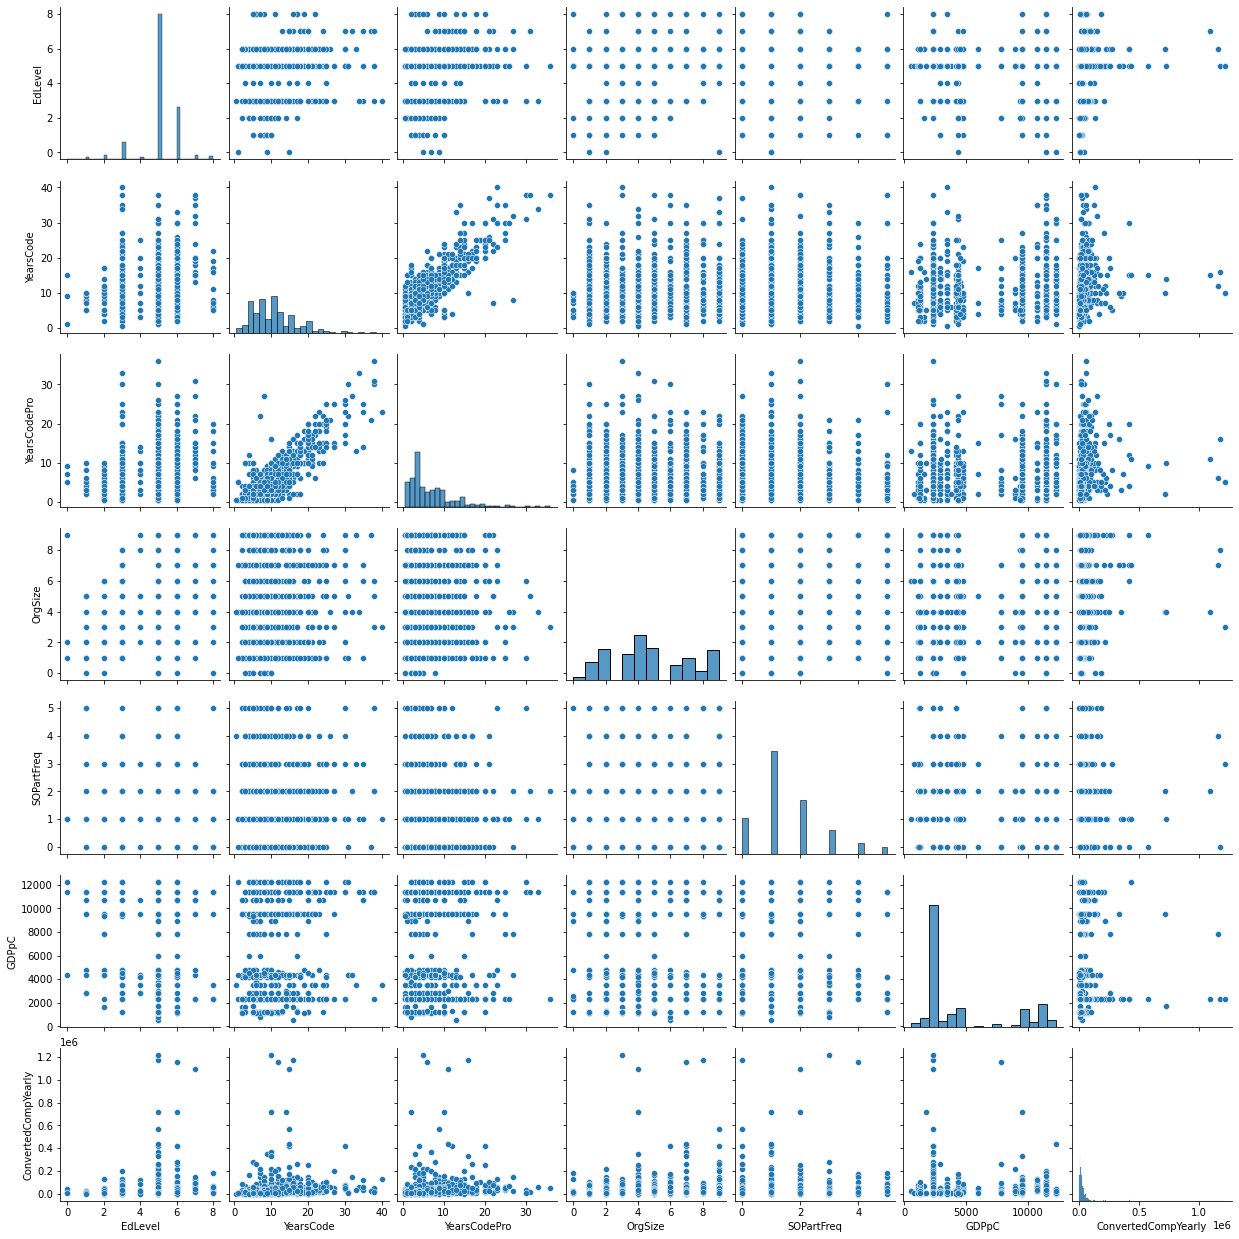

In [42]:
sns.pairplot(data=df_final[['EdLevel', 'YearsCode', 'YearsCodePro', 'OrgSize', 'SOPartFreq','GDPpC','ConvertedCompYearly']], diag_kind='hist')
plt.show()

Skewed features may need log transformation to improve model results. idk yet will initially try running models on not transformed data

In [43]:
df_final['YearsCodePro'].describe()

count    938.000000
mean       6.497868
std        5.344333
min        0.500000
25%        3.000000
50%        5.000000
75%        9.000000
max       36.000000
Name: YearsCodePro, dtype: float64

<AxesSubplot:ylabel='Frequency'>

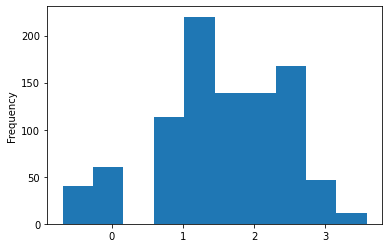

In [44]:
df_final['YearsCodePro'] = df_final['YearsCodePro'].copy().apply(np.log)
df_final['YearsCodePro'].plot(kind='hist')

<AxesSubplot:ylabel='Frequency'>

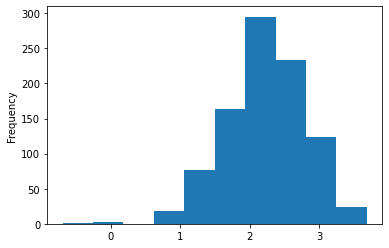

In [45]:
df_final['YearsCode'] = df_final['YearsCode'].copy().apply(np.log)
df_final['YearsCode'].plot(kind='hist')

In [46]:
# df_final['GDPpC'] = df_final['GDPpC'].copy().apply(np.log)
# df_final['GDPpC'].plot(kind='hist')


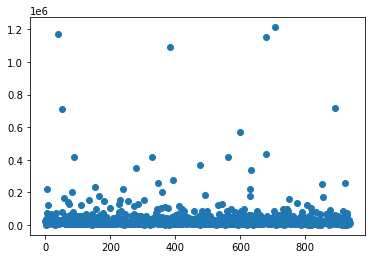

In [47]:
plt.scatter(
    df_final[['ConvertedCompYearly']].reset_index().drop(columns='index', axis=0).index,
    df_final[['ConvertedCompYearly']].reset_index().drop(columns='index', axis=0))

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


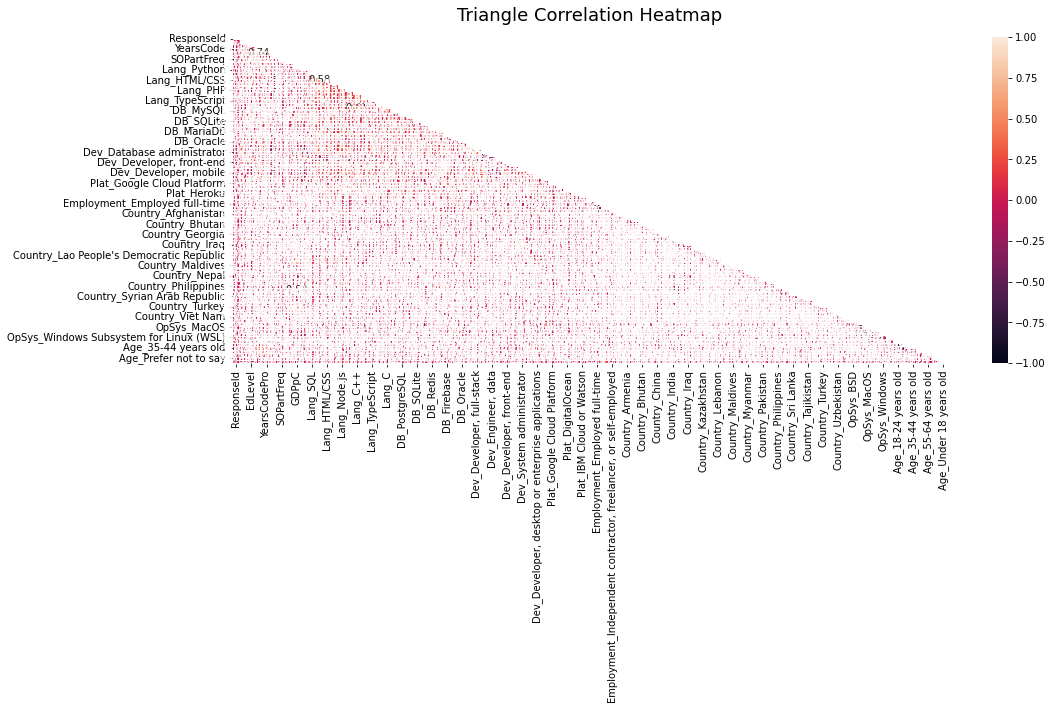

In [48]:
# code snippet for triangle correlation heatmap

def get_tri_corr_matrix(df_eda, figsize):
    
    plt.figure(figsize=figsize)
    # define the mask to set the values in the upper triangle to True

    mask = np.triu(np.ones_like(df_eda.corr(), dtype=np.bool))
    heatmap = sns.heatmap(df_eda.corr(), mask=mask, vmin=-1, vmax=1, annot=True)
    heatmap.set_title('Triangle Correlation Heatmap', fontdict={'fontsize':18}, pad=16);

get_tri_corr_matrix(df_final, (16,6))

<AxesSubplot:>

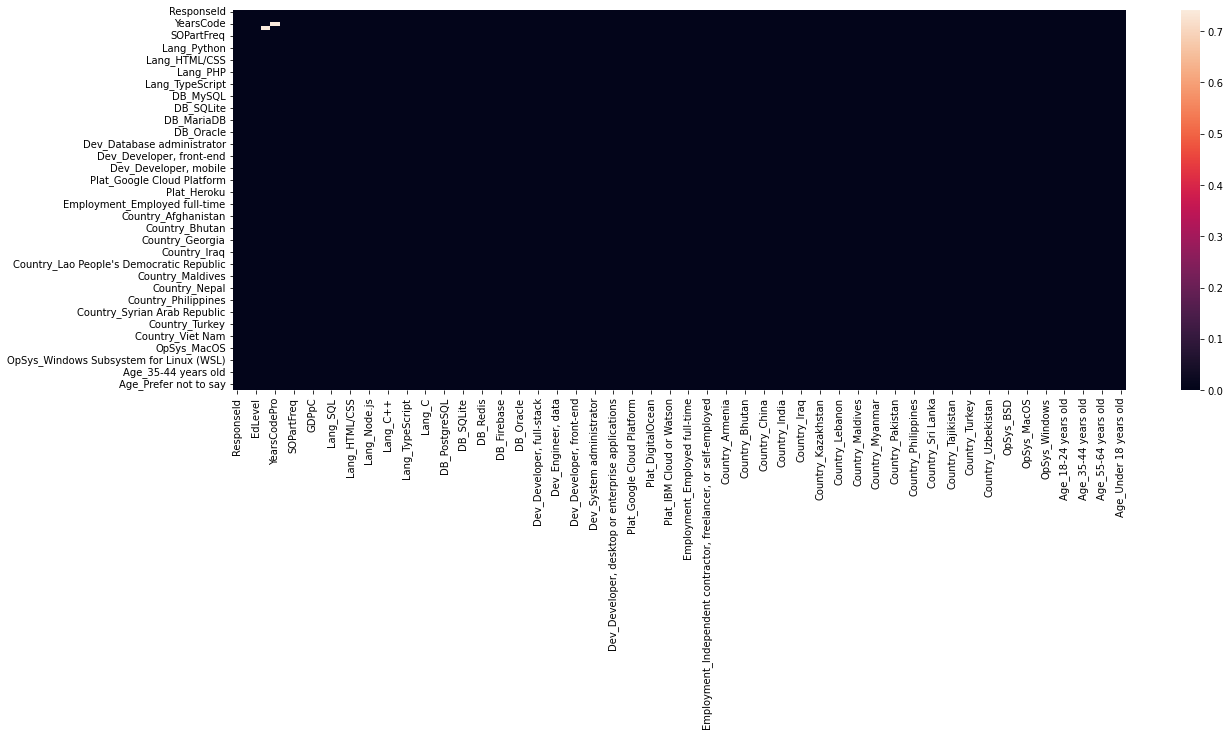

In [49]:
fig, ax = plt.subplots(figsize=(20,7))
sns.heatmap(df_final.corr().applymap(lambda x: x if (x>=0.65) and (x!=1.0) else 0))

In [50]:
corr = df_final.corr().applymap(lambda x: x if (x>=0.60) and (x!=1.0) else np.nan)
i=0
for col in corr.columns:
    
    filtered = corr[[col]].dropna()
    if len(filtered)>0:
        print(col, filtered.index.tolist(), '\n------')
        display(filtered.sum().values)
    # if filtered.sum().values > 0:
    #     display(filtered)

YearsCode ['YearsCodePro'] 
------


array([0.74180975])

YearsCodePro ['YearsCode'] 
------


array([0.74180975])

GDPpC ['Country_Russian Federation'] 
------


array([0.61503787])

Lang_C++ ['Lang_C'] 
------


array([0.6142377])

Lang_C ['Lang_C++'] 
------


array([0.6142377])

Country_Russian Federation ['GDPpC'] 
------


array([0.61503787])

## Removing Outliers

### Manual Outlier detection (OFF if isoforest is ON)

In [51]:
# idx_outliers_y = df_final['ConvertedCompYearly'].sort_values(ascending=False).head(10).index.to_list()
# display(df_drop.loc[idx_outliers_y,:])
# df_final = df_final.drop(idx_outliers_y, axis=0)
# df_final

### Testing isolation forest for outlier detection

In [52]:
from sklearn.ensemble import IsolationForest
isoforest = IsolationForest(n_estimators=100, max_samples='auto', contamination=0.12 , max_features=1, random_state=11)
isoforest.fit(df_final[['ConvertedCompYearly']])

df_final['scores']=isoforest.decision_function(df_final[['ConvertedCompYearly']])
df_final['anomaly']=isoforest.predict(df_final[['ConvertedCompYearly']])

X does not have valid feature names, but IsolationForest was fitted with feature names


In [53]:
outliers_iso = df_final[df_final['anomaly']==-1].index
print('number of outliers: ', len(outliers_iso), '\n shape of df_final with outliers: ', df_final.shape)
df_final.drop(outliers_iso, axis=0, inplace=True)

number of outliers:  113 
 shape of df_final with outliers:  (938, 97)


In [54]:
df_final

,ResponseId,MainBranch,EdLevel,YearsCode,YearsCodePro,OrgSize,SOPartFreq,ConvertedCompYearly,GDPpC,Lang_Python,...,OpSys_Windows Subsystem for Linux (WSL),Age_18-24 years old,Age_25-34 years old,Age_35-44 years old,Age_45-54 years old,Age_55-64 years old,Age_Prefer not to say,Age_Under 18 years old,scores,anomaly
index,,,,,,,,,,,,,,,,,,,,,
58,59,0,8,1.609438,1.098612,4,1,22644,11428,1,...,0,0,1,0,0,0,0,0,0.092767,1
148,149,0,6,0.693147,0.693147,1,5,36000,4184,0,...,0,0,1,0,0,0,0,0,0.065020,1
154,155,1,5,2.995732,1.945910,1,4,2340,2338,1,...,0,0,1,0,0,0,0,0,0.031921,1
168,169,1,3,1.386294,0.693147,1,4,14844,4746,1,...,0,1,0,0,0,0,0,0,0.098255,1
554,555,1,5,1.098612,0.000000,1,3,11724,2338,0,...,0,1,0,0,0,0,0,0,0.109989,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83046,83047,0,6,2.639057,2.397895,4,4,13962,2338,0,...,0,0,1,0,0,0,0,0,0.102653,1
83291,83292,1,5,1.609438,0.693147,9,3,5026,2338,1,...,0,1,0,0,0,0,0,0,0.099744,1
83294,83295,1,3,2.708050,2.564949,4,0,30192,11428,0,...,0,0,1,0,0,0,0,0,0.078415,1


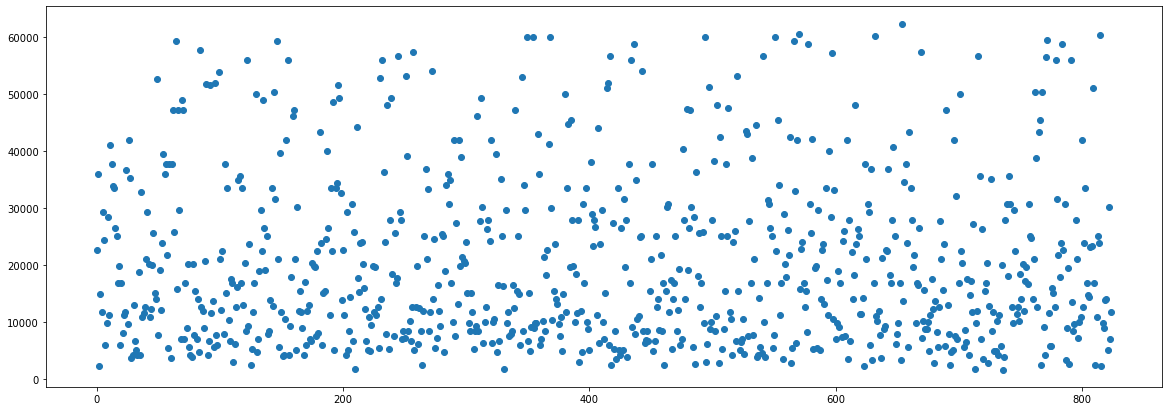

In [55]:
fig, ax = plt.subplots(figsize=(20,7))
plt.scatter(
    df_final[['ConvertedCompYearly']].reset_index().drop(columns='index', axis=0).index,
    df_final[['ConvertedCompYearly']].reset_index().drop(columns='index', axis=0))

## Adding/Removing features

In [56]:
def filter_lang(prefix):
    li = []
    for elem in df_final.columns:
        if prefix in elem:
            li.append(elem)
    return li

lang_cols = filter_lang('Lang_')
df_final['LCount'] = df_final[lang_cols].sum(axis=1)

dev_cols = filter_lang('Dev_')
df_final['DCount'] = df_final[dev_cols].sum(axis=1)

plat_cols = filter_lang('Plat_')
df_final['PCount'] = df_final[plat_cols].sum(axis=1)

db_cols = filter_lang('DB_')
df_final['DbCount'] = df_final[db_cols].sum(axis=1)


country_cols = filter_lang('Country_')
# country_cols = []

# removing language, devs, plat, db, country cols
# df_final = df_final.drop(
#     lang_cols+dev_cols+plat_cols+db_cols+country_cols, axis=1
# )


# removing platforms, database, country features only
# df_final = df_final.drop(
#     plat_cols+db_cols+country_cols, axis=1
# )

# removing platforms, database features only 
# df_final = df_final.drop(
#     plat_cols+db_cols, axis=1
# )

# removing lang, platforms, database features only 
# df_final = df_final.drop(
#     lang_cols+plat_cols+db_cols, axis=1
# )




df_final #best so far 12:24AM nov 27

,ResponseId,MainBranch,EdLevel,YearsCode,YearsCodePro,OrgSize,SOPartFreq,ConvertedCompYearly,GDPpC,Lang_Python,...,Age_45-54 years old,Age_55-64 years old,Age_Prefer not to say,Age_Under 18 years old,scores,anomaly,LCount,DCount,PCount,DbCount
index,,,,,,,,,,,,,,,,,,,,,
58,59,0,8,1.609438,1.098612,4,1,22644,11428,1,...,0,0,0,0,0.092767,1,5,2,1,1
148,149,0,6,0.693147,0.693147,1,5,36000,4184,0,...,0,0,0,0,0.065020,1,1,2,1,1
154,155,1,5,2.995732,1.945910,1,4,2340,2338,1,...,0,0,0,0,0.031921,1,6,5,1,5
168,169,1,3,1.386294,0.693147,1,4,14844,4746,1,...,0,0,0,0,0.098255,1,4,3,2,1
554,555,1,5,1.098612,0.000000,1,3,11724,2338,0,...,0,0,0,0,0.109989,1,8,6,2,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83046,83047,0,6,2.639057,2.397895,4,4,13962,2338,0,...,0,0,0,0,0.102653,1,4,5,2,4
83291,83292,1,5,1.609438,0.693147,9,3,5026,2338,1,...,0,0,0,0,0.099744,1,5,2,1,4
83294,83295,1,3,2.708050,2.564949,4,0,30192,11428,0,...,0,0,0,0,0.078415,1,2,2,1,4


In [57]:
# Dropping
# df_final.drop(['YearsCode'], axis=1, inplace=True)

**Adding Gender** (gender didnt do anything NOv 26 9:09)

In [58]:

# df_with_gender = pd.merge(df_devs, df_raw[['Gender']], how='left', left_index=True, right_index=True)
# df_with_gender['Gender'] = df_with_gender['Gender'].replace(np.nan, df_with_gender['Gender'].mode().values[0])
# df_with_gender['Gender'] = df_with_gender['Gender'].replace('Man;Or, in your own words:', 'Man')
# df_with_gender['Gender'] = df_with_gender['Gender'].replace('Or, in your own words:', 'Neither')
# df_with_gender['Gender'] = df_with_gender['Gender'].replace('Prefer not to say', 'Undisclosed')
# df_with_gender['Gender'] = df_with_gender['Gender'].replace('Non-binary, genderqueer, or gender non-conforming', 'Neither')


# df_final = pd.merge(df_final, pd.get_dummies(df_with_gender['Gender'], prefix='Gender'), how='left', left_index=True, right_index=True)
# # df_final


### ETHNICITY
# df_with_eth = pd.merge(df_devs, df_raw[['Ethnicity']], how='left', left_index=True, right_index=True)
# df_with_eth['Ethnicity'] = df_with_eth['Ethnicity'].replace('White or of European descent', 'White')
# df_with_eth['Ethnicity'] = df_with_eth['Ethnicity'].replace('East Asian', 'Asian')
# df_with_eth['Ethnicity'] = df_with_eth['Ethnicity'].replace('Southeast Asian;South Asian;East Asian;Indigenous (such as Native American, Pacific Islander, or Indigenous Australian)', 'Asian')
# df_with_eth['Ethnicity'] = df_with_eth['Ethnicity'].replace('Prefer not to say', 'Undisclosed')
# df_with_eth['Ethnicity'] = df_with_eth['Ethnicity'].replace('Middle Eastern', 'Middle_Eastern')
# df_with_eth['Ethnicity'] = df_with_eth['Ethnicity'].replace('South Asian', 'Asian')
# df_with_eth['Ethnicity'] = df_with_eth['Ethnicity'].replace('Or, in your own words:', 'Undisclosed')
# df_with_eth['Ethnicity'] = df_with_eth['Ethnicity'].replace('South Asian;Or, in your own words:', 'Asian')
# df_with_eth['Ethnicity'] = df_with_eth['Ethnicity'].replace('Southeast Asian', 'Asian')
# df_with_eth['Ethnicity'] = df_with_eth['Ethnicity'].replace('Southeast Asian;South Asian', 'Asian')
# df_with_eth['Ethnicity'] = df_with_eth['Ethnicity'].replace(np.nan, df_with_eth['Ethnicity'].mode().values[0])
# df_with_eth['Ethnicity'] = df_with_eth['Ethnicity'].replace("I don't know", 'Not_Known')
# df_with_eth['Ethnicity'] = df_with_eth['Ethnicity'].replace('White or of European descent;Middle Eastern', 'Biracial')
# df_with_eth['Ethnicity'] = df_with_eth['Ethnicity'].replace("I don't know;Middle Eastern", 'Middle_Eastern')
# df_with_eth['Ethnicity'] = df_with_eth['Ethnicity'].replace('White or of European descent;Multiracial', 'White')
# df_with_eth['Ethnicity'] = df_with_eth['Ethnicity'].replace('Southeast Asian;East Asian', 'Asian')
# df_with_eth['Ethnicity'] = df_with_eth['Ethnicity'].replace('Multiracial;Middle Eastern', 'Multi')
# df_with_eth['Ethnicity'] = df_with_eth['Ethnicity'].replace('East Asian;Or, in your own words:', 'Asian')
# df_with_eth['Ethnicity'] = df_with_eth['Ethnicity'].replace('Southeast Asian;South Asian;Middle Eastern;East Asian', 'Asian')
# df_with_eth['Ethnicity'] = df_with_eth['Ethnicity'].replace('Southeast Asian;South Asian;East Asian', 'Asian')
# df_with_eth['Ethnicity'] = df_with_eth['Ethnicity'].replace("White or of European descent;I don't know", 'White')
# df_with_eth['Ethnicity'] = df_with_eth['Ethnicity'].replace("I don't know;South Asian", 'Asian')
# df_with_eth['Ethnicity'] = df_with_eth['Ethnicity'].replace('Middle Eastern;Biracial', 'Biracial')
# df_with_eth['Ethnicity'] = df_with_eth['Ethnicity'].replace('Hispanic or Latino/a/x', 'Latino')
# df_with_eth['Ethnicity'] = df_with_eth['Ethnicity'].replace('Southeast Asian;South Asian;Or, in your own words:', 'Asian')
# df_with_eth['Ethnicity'] = df_with_eth['Ethnicity'].replace('Middle Eastern;East Asian', 'Biracial')
# df_with_eth['Ethnicity'] = df_with_eth['Ethnicity'].replace("I don't know;Or, in your own words:", 'Not_Known')
# df_with_eth['Ethnicity'] = df_with_eth['Ethnicity'].replace('South Asian;Middle Eastern', 'Biracial')
# df_with_eth['Ethnicity'] = df_with_eth['Ethnicity'].replace('White or of European descent;East Asian;Biracial', 'Biracial')
# df_with_eth['Ethnicity'] = df_with_eth['Ethnicity'].replace('Multiracial', 'Multi')
# df_with_eth['Ethnicity'] = df_with_eth['Ethnicity'].replace('Black or of African descent', 'African')
# df_with_eth['Ethnicity'] = df_with_eth['Ethnicity'].replace('South Asian;East Asian', 'Asian')
# df_with_eth['Ethnicity'] = df_with_eth['Ethnicity'].replace("I don't know;Southeast Asian", 'Asian')
# df_with_eth['Ethnicity'] = df_with_eth['Ethnicity'].replace('White or of European descent;Hispanic or Latino/a/x', 'Multi')
# df_with_eth['Ethnicity'] = df_with_eth['Ethnicity'].replace('White or of European descent;South Asian;Hispanic or Latino/a/x', 'Multi')
# df_with_eth['Ethnicity'] = df_with_eth['Ethnicity'].replace('Middle Eastern;Indigenous (such as Native American, Pacific Islander, or Indigenous Australian)', 'Multi')
# df_with_eth['Ethnicity'] = df_with_eth['Ethnicity'].replace('Southeast Asian;Middle Eastern;Biracial', 'Biracial')
# df_with_eth['Ethnicity'] = df_with_eth['Ethnicity'].replace('Biracial', 'Biracial')
# df_with_eth['Ethnicity'] = df_with_eth['Ethnicity'].replace("White or of European descent;I don't know;Multiracial;Southeast Asian;South Asian;Hispanic or Latino/a/x;Middle Eastern;East Asian;Biracial;Black or of African descent;Indigenous (such as Native American, Pacific Islander, or Indigenous Australian)", 'Multi')
# df_with_eth['Ethnicity'] = df_with_eth['Ethnicity'].replace('White or of European descent;Multiracial;Middle Eastern', 'Multi')
# df_with_eth['Ethnicity'] = df_with_eth['Ethnicity'].replace("White or of European descent;I don't know;Or, in your own words:", 'White')
# df_with_eth['Ethnicity'] = df_with_eth['Ethnicity'].replace('White or of European descent;Biracial;Black or of African descent', 'Multi')

# df_with_eth.Ethnicity.unique()
# df_final = pd.merge(df_final, pd.get_dummies(df_with_eth['Ethnicity'], prefix='Eth'), how='left', left_index=True, right_index=True)
df_final

,ResponseId,MainBranch,EdLevel,YearsCode,YearsCodePro,OrgSize,SOPartFreq,ConvertedCompYearly,GDPpC,Lang_Python,...,Age_45-54 years old,Age_55-64 years old,Age_Prefer not to say,Age_Under 18 years old,scores,anomaly,LCount,DCount,PCount,DbCount
index,,,,,,,,,,,,,,,,,,,,,
58,59,0,8,1.609438,1.098612,4,1,22644,11428,1,...,0,0,0,0,0.092767,1,5,2,1,1
148,149,0,6,0.693147,0.693147,1,5,36000,4184,0,...,0,0,0,0,0.065020,1,1,2,1,1
154,155,1,5,2.995732,1.945910,1,4,2340,2338,1,...,0,0,0,0,0.031921,1,6,5,1,5
168,169,1,3,1.386294,0.693147,1,4,14844,4746,1,...,0,0,0,0,0.098255,1,4,3,2,1
554,555,1,5,1.098612,0.000000,1,3,11724,2338,0,...,0,0,0,0,0.109989,1,8,6,2,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83046,83047,0,6,2.639057,2.397895,4,4,13962,2338,0,...,0,0,0,0,0.102653,1,4,5,2,4
83291,83292,1,5,1.609438,0.693147,9,3,5026,2338,1,...,0,0,0,0,0.099744,1,5,2,1,4
83294,83295,1,3,2.708050,2.564949,4,0,30192,11428,0,...,0,0,0,0,0.078415,1,2,2,1,4


**Adding Original Country Column for statified splitting**

In [59]:
df_final = pd.concat([df_final, df_devs['Country']], axis=1)
df_final.dropna(inplace=True)
df_final

,ResponseId,MainBranch,EdLevel,YearsCode,YearsCodePro,OrgSize,SOPartFreq,ConvertedCompYearly,GDPpC,Lang_Python,...,Age_55-64 years old,Age_Prefer not to say,Age_Under 18 years old,scores,anomaly,LCount,DCount,PCount,DbCount,Country
index,,,,,,,,,,,,,,,,,,,,,
58,59.0,0.0,8.0,1.609438,1.098612,4.0,1.0,22644.0,11428.0,1.0,...,0.0,0.0,0.0,0.092767,1.0,5.0,2.0,1.0,1.0,Russian Federation
148,149.0,0.0,6.0,0.693147,0.693147,1.0,5.0,36000.0,4184.0,0.0,...,0.0,0.0,0.0,0.065020,1.0,1.0,2.0,1.0,1.0,Sri Lanka
154,155.0,1.0,5.0,2.995732,1.945910,1.0,4.0,2340.0,2338.0,1.0,...,0.0,0.0,0.0,0.031921,1.0,6.0,5.0,1.0,5.0,India
168,169.0,1.0,3.0,1.386294,0.693147,1.0,4.0,14844.0,4746.0,1.0,...,0.0,0.0,0.0,0.098255,1.0,4.0,3.0,2.0,1.0,Georgia
554,555.0,1.0,5.0,1.098612,0.000000,1.0,3.0,11724.0,2338.0,0.0,...,0.0,0.0,0.0,0.109989,1.0,8.0,6.0,2.0,3.0,India
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83046,83047.0,0.0,6.0,2.639057,2.397895,4.0,4.0,13962.0,2338.0,0.0,...,0.0,0.0,0.0,0.102653,1.0,4.0,5.0,2.0,4.0,India
83291,83292.0,1.0,5.0,1.609438,0.693147,9.0,3.0,5026.0,2338.0,1.0,...,0.0,0.0,0.0,0.099744,1.0,5.0,2.0,1.0,4.0,India
83294,83295.0,1.0,3.0,2.708050,2.564949,4.0,0.0,30192.0,11428.0,0.0,...,0.0,0.0,0.0,0.078415,1.0,2.0,2.0,1.0,4.0,Russian Federation


**Removing countries that have less than 5 data points**

In [60]:
drop_list = []
for country in df_final['Country'].unique():
    df = df_final[df_final['Country']==country]
    if len(df) < 5:
        for elem in df.index:
            drop_list.append(elem)
drop_list

[1123,
 16606,
 75916,
 76801,
 2727,
 4635,
 13322,
 81208,
 3237,
 13170,
 68563,
 7430,
 27344,
 37107,
 57997,
 10863,
 73322,
 20599,
 37053,
 22332,
 80271,
 80339,
 82600,
 27929,
 40296,
 48074,
 28176,
 73176,
 31086,
 40606,
 53378,
 58856,
 44472,
 45761,
 48304,
 56826,
 59424,
 75763]

In [61]:
df_final.loc[drop_list]

,ResponseId,MainBranch,EdLevel,YearsCode,YearsCodePro,OrgSize,SOPartFreq,ConvertedCompYearly,GDPpC,Lang_Python,...,Age_55-64 years old,Age_Prefer not to say,Age_Under 18 years old,scores,anomaly,LCount,DCount,PCount,DbCount,Country
index,,,,,,,,,,,,,,,,,,,,,
1123,1124.0,1.0,4.0,2.833213,2.564949,3.0,3.0,33852.0,4374.0,0.0,...,0.0,0.0,0.0,0.070834,1.0,7.0,5.0,1.0,5.0,Jordan
16606,16607.0,1.0,2.0,1.609438,1.609438,3.0,1.0,16920.0,4374.0,0.0,...,0.0,0.0,0.0,0.107033,1.0,4.0,4.0,3.0,8.0,Jordan
75916,75917.0,1.0,6.0,2.708050,1.609438,5.0,1.0,30606.0,4374.0,1.0,...,0.0,0.0,0.0,0.073989,1.0,7.0,3.0,1.0,6.0,Jordan
76801,76802.0,1.0,5.0,1.791759,-0.693147,2.0,1.0,2388.0,4374.0,0.0,...,0.0,0.0,0.0,0.032822,1.0,6.0,3.0,2.0,2.0,Jordan
2727,2728.0,1.0,6.0,2.302585,1.609438,3.0,2.0,9600.0,1213.0,0.0,...,0.0,0.0,0.0,0.104743,1.0,10.0,7.0,1.0,2.0,Syrian Arab Republic
4635,4636.0,1.0,5.0,2.995732,2.302585,1.0,5.0,20000.0,1213.0,0.0,...,0.0,0.0,0.0,0.092676,1.0,7.0,8.0,1.0,2.0,Syrian Arab Republic
13322,13323.0,1.0,6.0,1.791759,1.386294,4.0,2.0,6996.0,1213.0,1.0,...,0.0,0.0,0.0,0.114452,1.0,7.0,3.0,1.0,4.0,Syrian Arab Republic
81208,81209.0,1.0,5.0,1.609438,0.000000,2.0,0.0,23304.0,1213.0,1.0,...,0.0,0.0,0.0,0.091651,1.0,3.0,1.0,1.0,2.0,Syrian Arab Republic
3237,3238.0,1.0,6.0,2.833213,2.708050,5.0,2.0,35232.0,5997.0,1.0,...,0.0,0.0,0.0,0.066762,1.0,7.0,4.0,1.0,5.0,Iraq


In [62]:
df_final.drop(drop_list, inplace=True)
df_final

,ResponseId,MainBranch,EdLevel,YearsCode,YearsCodePro,OrgSize,SOPartFreq,ConvertedCompYearly,GDPpC,Lang_Python,...,Age_55-64 years old,Age_Prefer not to say,Age_Under 18 years old,scores,anomaly,LCount,DCount,PCount,DbCount,Country
index,,,,,,,,,,,,,,,,,,,,,
58,59.0,0.0,8.0,1.609438,1.098612,4.0,1.0,22644.0,11428.0,1.0,...,0.0,0.0,0.0,0.092767,1.0,5.0,2.0,1.0,1.0,Russian Federation
148,149.0,0.0,6.0,0.693147,0.693147,1.0,5.0,36000.0,4184.0,0.0,...,0.0,0.0,0.0,0.065020,1.0,1.0,2.0,1.0,1.0,Sri Lanka
154,155.0,1.0,5.0,2.995732,1.945910,1.0,4.0,2340.0,2338.0,1.0,...,0.0,0.0,0.0,0.031921,1.0,6.0,5.0,1.0,5.0,India
168,169.0,1.0,3.0,1.386294,0.693147,1.0,4.0,14844.0,4746.0,1.0,...,0.0,0.0,0.0,0.098255,1.0,4.0,3.0,2.0,1.0,Georgia
554,555.0,1.0,5.0,1.098612,0.000000,1.0,3.0,11724.0,2338.0,0.0,...,0.0,0.0,0.0,0.109989,1.0,8.0,6.0,2.0,3.0,India
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83046,83047.0,0.0,6.0,2.639057,2.397895,4.0,4.0,13962.0,2338.0,0.0,...,0.0,0.0,0.0,0.102653,1.0,4.0,5.0,2.0,4.0,India
83291,83292.0,1.0,5.0,1.609438,0.693147,9.0,3.0,5026.0,2338.0,1.0,...,0.0,0.0,0.0,0.099744,1.0,5.0,2.0,1.0,4.0,India
83294,83295.0,1.0,3.0,2.708050,2.564949,4.0,0.0,30192.0,11428.0,0.0,...,0.0,0.0,0.0,0.078415,1.0,2.0,2.0,1.0,4.0,Russian Federation


In [120]:
df_final.columns

Index(['ResponseId', 'MainBranch', 'EdLevel', 'YearsCode', 'YearsCodePro',
       'OrgSize', 'SOPartFreq', 'ConvertedCompYearly', 'GDPpC', 'Lang_Python',
       ...
       'Age_55-64 years old', 'Age_Prefer not to say',
       'Age_Under 18 years old', 'scores', 'anomaly', 'LCount', 'DCount',
       'PCount', 'DbCount', 'Country'],
      dtype='object', length=102)

# ML

In [63]:
X = df_final[df_final.columns.difference(['ConvertedCompYearly', 'ResponseId', 'scores', 'anomaly'])]
y = df_final['ConvertedCompYearly']

In [64]:
X.columns

Index(['Age_18-24 years old', 'Age_25-34 years old', 'Age_35-44 years old',
       'Age_45-54 years old', 'Age_55-64 years old', 'Age_Prefer not to say',
       'Age_Under 18 years old', 'Country', 'Country_Afghanistan',
       'Country_Armenia', 'Country_Azerbaijan', 'Country_Bhutan',
       'Country_Cambodia', 'Country_China', 'Country_Georgia', 'Country_India',
       'Country_Indonesia', 'Country_Iraq', 'Country_Jordan',
       'Country_Kazakhstan', 'Country_Lao People's Democratic Republic',
       'Country_Lebanon', 'Country_Malaysia', 'Country_Maldives',
       'Country_Mongolia', 'Country_Myanmar', 'Country_Nepal',
       'Country_Pakistan', 'Country_Palestine', 'Country_Philippines',
       'Country_Russian Federation', 'Country_Sri Lanka',
       'Country_Syrian Arab Republic', 'Country_Tajikistan',
       'Country_Thailand', 'Country_Turkey', 'Country_Turkmenistan',
       'Country_Uzbekistan', 'Country_Viet Nam', 'DB_Elasticsearch',
       'DB_Firebase', 'DB_MariaDB', 'DB_M

## Logged y

since y is initially skewed

In [65]:

# y = np.log(y)
y

index
58       22644.0
148      36000.0
154       2340.0
168      14844.0
554      11724.0
          ...   
83046    13962.0
83291     5026.0
83294    30192.0
83356     7020.0
83431    11676.0
Name: ConvertedCompYearly, Length: 787, dtype: float64

## Train-Test Split

In [66]:
(X_trainval, X_holdout, y_trainval, y_holdout) = train_test_split(X, y, 
                                           random_state=11, test_size=0.25, stratify=X['Country'])

## CV

In [67]:
# def testing_optimal_model(model, n_trials):

#     mae_list = []
#     for n in tqdm_notebook(range(n_trials)):

#         (X_train, X_test, y_train, y_test) = train_test_split(X, y,
#                                                               random_state=n, 
#                                                               test_size=0.25)
#         scaler = MinMaxScaler()

#         X_train_scaled = scaler.fit_transform(X_train)
#         X_test_scaled = scaler.transform(X_test)

#         model.fit(X_train_scaled, y_train)
#         y_pred = model.predict(X_test_scaled)

#         mae = mean_absolute_error(np.exp(y_test), np.exp(y_pred)) # on 
#         mae_list.append(mae)
#     return np.mean(mae_list)

## CV but minmax scaling based on country

In [68]:
# skf = StratifiedKFold(n_splits=4)


# X = X_trainval
# y = y_trainval
# mae_list=[]
# for train_idx, val_idx in skf.split(X, X['Country']):
#     X_train, y_train = X.iloc[train_idx,:], y.iloc[train_idx]
#     X_val, y_val = X.iloc[val_idx,:], y.iloc[val_idx]
    
#     ### Fitting scalers per country
#     def get_country_index(X, country):
#         return X[X[f'Country_{country}']==1].index
    
#     country_list = X['Country'].unique().tolist()
#     country_index_dict = {}
#     for c in country_list:
#         scaler = MinMaxScaler()
#         scaler.fit(np.array(y_train[get_country_index(X_train, c)]).reshape(-1,1))
#         country_index_dict[c] = [get_country_index(X_train, c), scaler]

#     #### scaling train sets
#     # y
#     ytrain_scaled_dict = {}
#     for key, val in country_index_dict.items():
#         y_train_scaled = val[1].transform(np.array(y_train[val[0]]).reshape(-1,1))
#         ytrain_scaled_dict[key] = pd.Series(y_train_scaled.ravel(), index=val[0])
        
#     y_train_final = pd.concat(ytrain_scaled_dict.values(), axis=0)
    
#     # X 
#     X_train_final = X_train.drop(columns=['Country'], axis=0)
    
#     y_train_final.name = 'y'
#     y_train_final = pd.merge(X_train_final, y_train_final, left_index=True, right_index=True)['y']
    
    
#     #### scaling val sets
#     # y
    
#     country_index_val_dict = {}
#     for c in country_list:
#         scaler = MinMaxScaler()
#         scaler.fit(np.array(y_val[get_country_index(X_val, c)]).reshape(-1,1))
#         country_index_val_dict[c] = [get_country_index(X_val, c), scaler]

    
#     yval_scaled_dict = {}
#     for key, val in country_index_val_dict.items():
#         y_val_scaled = val[1].transform(np.array(y_val[val[0]]).reshape(-1,1))
#         yval_scaled_dict[key] = pd.Series(y_val_scaled.ravel(), index=val[0])
    
#     y_val_final = pd.concat(yval_scaled_dict.values(), axis=0)
    
#     # X
#     X_val_final = X_val.drop(columns=['Country'], axis=0)
    
    
#     y_val_final.name = 'y'
#     y_val_final = pd.merge(X_val_final, y_val_final, left_index=True, right_index=True)['y']
    
    
    
#     scaler = MinMaxScaler()
#     X_train_feed = scaler.fit_transform(X_train_final)
#     X_val_feed = scaler.transform(X_val_final)
    
#     model = GradientBoostingRegressor() ####### OFF WHEN PASTING TO OPTUNA
#     model.fit(X_train_feed, y_train_final)

#     y_pred = model.predict(X_val_feed)
    
# #     ### Inverse scaling before calculating MAE
#     y_pred_dict = {}
#     for key, val in country_index_val_dict.items():
#         val_indices = X_val_final.reset_index()[X_val_final.reset_index()[f'Country_{key}']==1].index
#         y_country = y_pred[val_indices]
#         # inverse minmax scaling....
#         y_country_inversed_scaled = val[1].inverse_transform(np.array(y_country).reshape(-1,1))
#         y_pred_dict[key] = [val_indices, y_country_inversed_scaled.ravel(), val[1]]
    
    
#     y_val_dict = {}
#     for key, val in y_pred_dict.items():
#         y_val_country = y_val_final.reset_index(drop=True)[val[0]]
#         y_val_country_inversed_scaled = val[2].inverse_transform(np.array(y_val_country).reshape(-1,1))
#         y_val_dict[key] = y_val_country_inversed_scaled.ravel()
        
#     y_val_sorted = [list(elem) for elem in y_val_dict.values()]
#     y_val_mae = []
#     for elem in y_val_sorted:
#         y_val_mae = y_val_mae + elem
  
#     y_pred_sorted = [list(elem[1]) for elem in y_pred_dict.values()]
#     y_pred_mae = []
#     for elem in y_pred_sorted:
#         y_pred_mae = y_pred_mae + elem
    
    
#     mae = mean_absolute_error(y_val_mae, y_pred_mae)
#     mae_list.append(mae)
#     break

In [69]:
# mae_list

In [70]:
# y_val_sorted
# # y_pred_dict

In [71]:
# y_val_final

In [122]:
def tune_GBM(X, y):
    from sklearn.ensemble import GradientBoostingRegressor
    from sklearn.model_selection import cross_validate
    
    def optimize(trial):
        # Definition of space search
        n_estimators = trial.suggest_int('n_estimators', 10,800, step=10)
        max_depth = trial.suggest_int('max_depth', 2,15)
        # max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2'])
        max_features = trial.suggest_int('max_features', 2, X.shape[1]-1)
        learning_rate = trial.suggest_float('learning_rate', 1e-6, 1e-1)
        
        # Classifier definition
        model = GradientBoostingRegressor(n_estimators=n_estimators,
                                           max_depth=max_depth,
                                           max_features=max_features,
                                           learning_rate=learning_rate, random_state=11)

        scaler = MinMaxScaler()
        
        pipe = Pipeline(steps = [['scale', scaler],['gbm', model]]) #on
        
#         cr_val = cross_val_score(rf_pipe, X, y, cv=5, scoring=make_scorer(mean_absolute_error)) #on
        
        skf = StratifiedKFold(n_splits=4)
        mae_list=[]
        for train_idx, val_idx in skf.split(X, X['Country']):
            X_train, y_train = X.iloc[train_idx,:], y.iloc[train_idx]
            X_val, y_val = X.iloc[val_idx,:], y.iloc[val_idx]

            ### Fitting scalers per country
            def get_country_index(X, country):
                return X[X[f'Country_{country}']==1].index

            country_list = X['Country'].unique().tolist()
            country_index_dict = {}
            for c in country_list:
                scaler = MinMaxScaler()
                scaler.fit(np.array(y_train[get_country_index(X_train, c)]).reshape(-1,1))
                country_index_dict[c] = [get_country_index(X_train, c), scaler]

            #### scaling train sets
            # y
            ytrain_scaled_dict = {}
            for key, val in country_index_dict.items():
                y_train_scaled = val[1].transform(np.array(y_train[val[0]]).reshape(-1,1))
                ytrain_scaled_dict[key] = pd.Series(y_train_scaled.ravel(), index=val[0])

            y_train_final = pd.concat(ytrain_scaled_dict.values(), axis=0)

            # X 
            X_train_final = X_train.drop(columns=['Country'], axis=0)

            y_train_final.name = 'y'
            y_train_final = pd.merge(X_train_final, y_train_final, left_index=True, right_index=True)['y']


            #### scaling val sets
            # y

            country_index_val_dict = {}
            for c in country_list:
                scaler = MinMaxScaler()
                scaler.fit(np.array(y_val[get_country_index(X_val, c)]).reshape(-1,1))
                country_index_val_dict[c] = [get_country_index(X_val, c), scaler]


            yval_scaled_dict = {}
            for key, val in country_index_val_dict.items():
                y_val_scaled = val[1].transform(np.array(y_val[val[0]]).reshape(-1,1))
                yval_scaled_dict[key] = pd.Series(y_val_scaled.ravel(), index=val[0])

            y_val_final = pd.concat(yval_scaled_dict.values(), axis=0)

            # X
            X_val_final = X_val.drop(columns=['Country'], axis=0)


            y_val_final.name = 'y'
            y_val_final = pd.merge(X_val_final, y_val_final, left_index=True, right_index=True)['y']



            scaler = MinMaxScaler()
            X_train_feed = scaler.fit_transform(X_train_final)
            X_val_feed = scaler.transform(X_val_final)

            model.fit(X_train_feed, y_train_final)

            y_pred = model.predict(X_val_feed)

        #     ### Inverse scaling before calculating MAE
            y_pred_dict = {}
            for key, val in country_index_val_dict.items():
                val_indices = X_val_final.reset_index()[X_val_final.reset_index()[f'Country_{key}']==1].index
                y_country = y_pred[val_indices]
                # inverse minmax scaling....
                y_country_inversed_scaled = val[1].inverse_transform(np.array(y_country).reshape(-1,1))
                y_pred_dict[key] = [val_indices, y_country_inversed_scaled.ravel(), val[1]]


            y_val_dict = {}
            for key, val in y_pred_dict.items():
                y_val_country = y_val_final.reset_index(drop=True)[val[0]]
                y_val_country_inversed_scaled = val[2].inverse_transform(np.array(y_val_country).reshape(-1,1))
                y_val_dict[key] = y_val_country_inversed_scaled.ravel()

            y_val_sorted = [list(elem) for elem in y_val_dict.values()]
            y_val_mae = []
            for elem in y_val_sorted:
                y_val_mae = y_val_mae + elem

            y_pred_sorted = [list(elem[1]) for elem in y_pred_dict.values()]
            y_pred_mae = []
            for elem in y_pred_sorted:
                y_pred_mae = y_pred_mae + elem

            
            mae = r2_score(y_val_mae, y_pred_mae)
            mae_list.append(mae)
        
    
    
        # return np.mean(cr_val) #on
        return np.mean(mae_list)
    
    study = optuna.create_study(direction='minimize')
    study.optimize(optimize, n_trials=70, n_jobs=4)
    return study, optimize

In [123]:
gbm_study, gbm_optimize = tune_GBM(X_trainval ,y_trainval)

[I 2021-11-29 21:47:19,138] A new study created in memory with name: no-name-9afcd217-7269-4bc3-95a3-83f21d794233
`n_jobs` argument has been deprecated in v2.7.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.7.0.
[I 2021-11-29 21:47:23,019] Trial 3 finished with value: 0.4176434429102751 and parameters: {'n_estimators': 640, 'max_depth': 2, 'max_features': 26, 'learning_rate': 0.06358049467875225}. Best is trial 3 with value: 0.4176434429102751.
[I 2021-11-29 21:47:24,324] Trial 0 finished with value: 0.41943763008905066 and parameters: {'n_estimators': 630, 'max_depth': 2, 'max_features': 72, 'learning_rate': 0.037123048423948785}. Best is trial 3 with value: 0.4176434429102751.
[I 2021-11-29 21:47:25,540] Trial 2 finished with value: 0.2813486383317222 and parameters: {'n_estimators': 140, 'max_depth': 11, 'max_features': 88, 'learning_rate': 0.05023929241546292}. Best is trial 2 with value: 0.2813486383317222.
[I 2021-11-29 21:47:27,13

In [126]:
gbm_study.best_value

0.07604395747071621

In [127]:
gbm_study.best_params

{'n_estimators': 700,
 'max_depth': 15,
 'max_features': 97,
 'learning_rate': 0.04075791792070886}

In [124]:
def testing_optimal_model(model, n_trials):

    mae_list=[]
    for n in tqdm_notebook(range(n_trials)):
        (X_train, X_val, y_train, y_val) = train_test_split(X, y,
                                                              random_state=n, 
                                                              test_size=0.25, stratify=X['Country'])

        ### Fitting scalers per country
        def get_country_index(X, country):
            return X[X[f'Country_{country}']==1].index

        country_list = X['Country'].unique().tolist()
        country_index_dict = {}
        for c in country_list:
            scaler = MinMaxScaler()
            scaler.fit(np.array(y_train[get_country_index(X_train, c)]).reshape(-1,1))
            country_index_dict[c] = [get_country_index(X_train, c), scaler]

        #### scaling train sets
        # y
        ytrain_scaled_dict = {}
        for key, val in country_index_dict.items():
            y_train_scaled = val[1].transform(np.array(y_train[val[0]]).reshape(-1,1))
            ytrain_scaled_dict[key] = pd.Series(y_train_scaled.ravel(), index=val[0])

        y_train_final = pd.concat(ytrain_scaled_dict.values(), axis=0)

        # X 
        X_train_final = X_train.drop(columns=['Country'], axis=0)

        y_train_final.name = 'y'
        y_train_final = pd.merge(X_train_final, y_train_final, left_index=True, right_index=True)['y']


        #### scaling val sets
        # y

        country_index_val_dict = {}
        for c in country_list:
            scaler = MinMaxScaler()
            scaler.fit(np.array(y_val[get_country_index(X_val, c)]).reshape(-1,1))
            country_index_val_dict[c] = [get_country_index(X_val, c), scaler]


        yval_scaled_dict = {}
        for key, val in country_index_val_dict.items():
            y_val_scaled = val[1].transform(np.array(y_val[val[0]]).reshape(-1,1))
            yval_scaled_dict[key] = pd.Series(y_val_scaled.ravel(), index=val[0])

        y_val_final = pd.concat(yval_scaled_dict.values(), axis=0)

        # X
        X_val_final = X_val.drop(columns=['Country'], axis=0)


        y_val_final.name = 'y'
        y_val_final = pd.merge(X_val_final, y_val_final, left_index=True, right_index=True)['y']



        scaler = MinMaxScaler()
        X_train_feed = scaler.fit_transform(X_train_final)
        X_val_feed = scaler.transform(X_val_final)

        model.fit(X_train_feed, y_train_final)

        y_pred = model.predict(X_val_feed)

    #     ### Inverse scaling before calculating MAE
        y_pred_dict = {}
        for key, val in country_index_val_dict.items():
            val_indices = X_val_final.reset_index()[X_val_final.reset_index()[f'Country_{key}']==1].index
            y_country = y_pred[val_indices]
            # inverse minmax scaling....
            y_country_inversed_scaled = val[1].inverse_transform(np.array(y_country).reshape(-1,1))
            y_pred_dict[key] = [val_indices, y_country_inversed_scaled.ravel(), val[1]]


        y_val_dict = {}
        for key, val in y_pred_dict.items():
            y_val_country = y_val_final.reset_index(drop=True)[val[0]]
            y_val_country_inversed_scaled = val[2].inverse_transform(np.array(y_val_country).reshape(-1,1))
            y_val_dict[key] = y_val_country_inversed_scaled.ravel()

        y_val_sorted = [list(elem) for elem in y_val_dict.values()]
        y_val_mae = []
        for elem in y_val_sorted:
            y_val_mae = y_val_mae + elem

        y_pred_sorted = [list(elem[1]) for elem in y_pred_dict.values()]
        y_pred_mae = []
        for elem in y_pred_sorted:
            y_pred_mae = y_pred_mae + elem


        mae = r2_score(y_val_mae, y_pred_mae)
        mae_list.append(mae)
    return np.mean(mae_list)

In [125]:
gbm = GradientBoostingRegressor(**gbm_study.best_params, random_state=11)
testing_optimal_model(gbm, 20)

  0%|          | 0/20 [00:00<?, ?it/s]

-0.014872087842948866

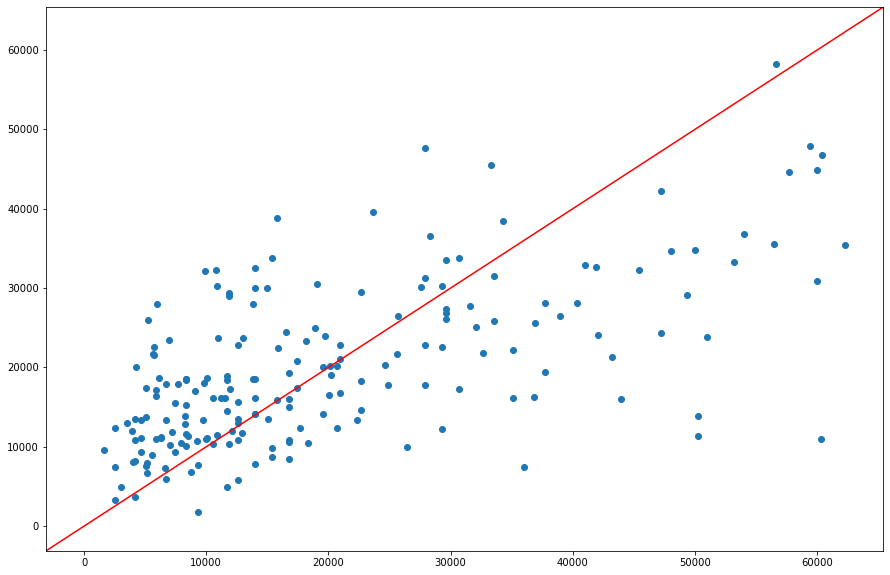

In [87]:
model = gbm.fit(X_trainval.drop(columns='Country'), y_trainval)
y_pred = model.predict(X_holdout.drop(columns='Country'))

fig, ax = plt.subplots(figsize=(15,10))

plt.scatter(y_holdout, y_pred)
ax.axline([0, 0], [y_holdout.max(), y_holdout.max()], color='red')
# plt.scatter(range(len(y_pred)), y_pred, label='preds')
# plt.legend()
plt.show()


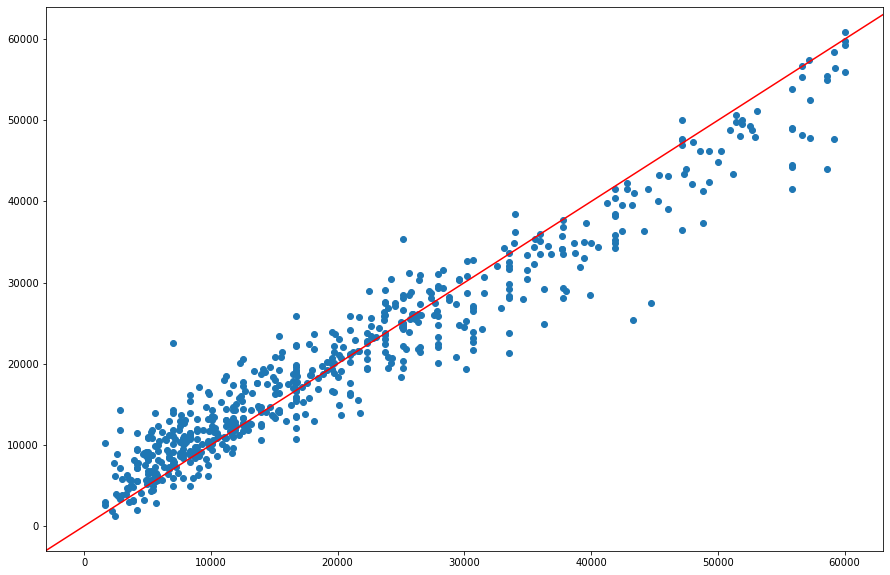

In [104]:
model = gbm.fit(X_trainval.drop(columns='Country'), y_trainval)
y_pred = model.predict(X_trainval.drop(columns='Country'))

fig, ax = plt.subplots(figsize=(15,10))

plt.scatter(y_trainval, y_pred)
ax.axline([0, 0], [y_trainval.max(), y_trainval.max()], color='red')
# plt.scatter(range(len(y_pred)), y_pred, label='preds')
# plt.legend()
plt.show()


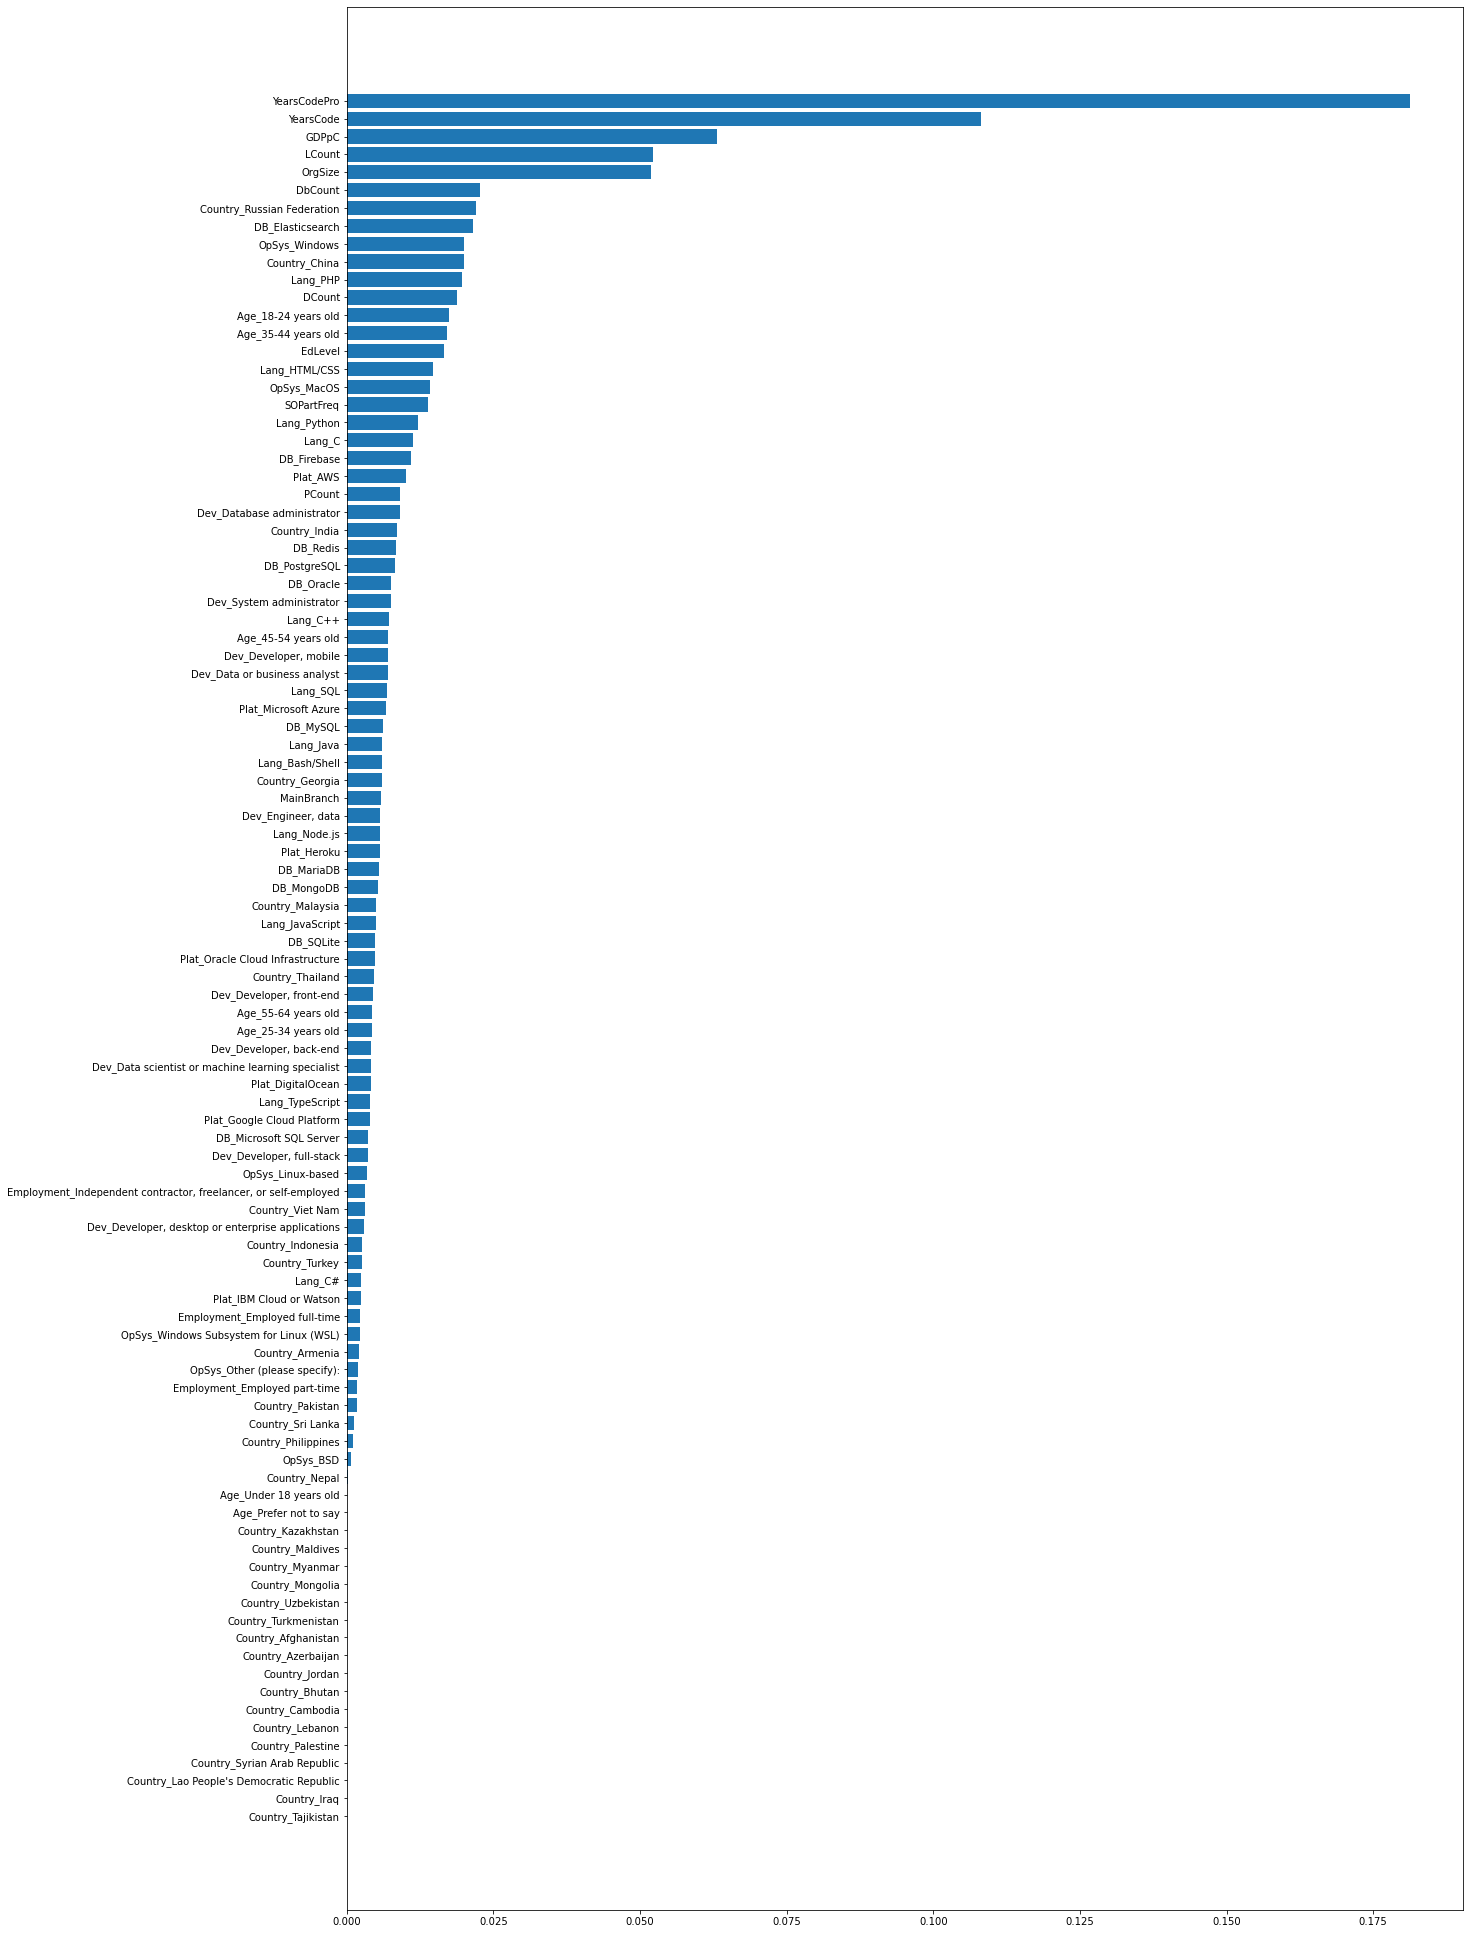

In [119]:
fig, ax = plt.subplots(figsize=(20,35))
plt.barh(X.columns.difference(['Country'])[gbm.feature_importances_.argsort()], gbm.feature_importances_[gbm.feature_importances_.argsort()])
plt.autoscale()

In [118]:
len(X.columns)
len(gbm.feature_importances_)

97

# EDA on making 2 models

In [107]:
df_final[df_final['ConvertedCompYearly']>30_000]

,ResponseId,MainBranch,EdLevel,YearsCode,YearsCodePro,OrgSize,SOPartFreq,ConvertedCompYearly,GDPpC,Lang_Python,...,Age_55-64 years old,Age_Prefer not to say,Age_Under 18 years old,scores,anomaly,LCount,DCount,PCount,DbCount,Country
index,,,,,,,,,,,,,,,,,,,,,
148,149.0,0.0,6.0,0.693147,0.693147,1.0,5.0,36000.0,4184.0,0.0,...,0.0,0.0,0.0,0.065020,1.0,1.0,2.0,1.0,1.0,Sri Lanka
1023,1024.0,1.0,5.0,1.791759,1.609438,8.0,1.0,41000.0,11428.0,1.0,...,0.0,0.0,0.0,0.062940,1.0,2.0,1.0,2.0,1.0,Russian Federation
1085,1086.0,1.0,3.0,3.637586,3.401197,6.0,5.0,37752.0,11428.0,1.0,...,0.0,0.0,0.0,0.064433,1.0,5.0,4.0,1.0,3.0,Russian Federation
1147,1148.0,1.0,5.0,2.772589,2.397895,3.0,2.0,33508.0,2338.0,0.0,...,0.0,0.0,0.0,0.071651,1.0,4.0,6.0,1.0,2.0,India
2726,2727.0,1.0,5.0,2.995732,2.708050,5.0,3.0,36576.0,1254.0,1.0,...,0.0,0.0,0.0,0.066362,1.0,8.0,4.0,3.0,5.0,Pakistan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80602,80603.0,1.0,5.0,2.302585,2.302585,6.0,1.0,41885.0,2338.0,1.0,...,0.0,0.0,0.0,0.067821,1.0,3.0,2.0,1.0,3.0,India
80792,80793.0,0.0,6.0,2.197225,1.791759,5.0,1.0,33508.0,2338.0,0.0,...,0.0,0.0,0.0,0.071651,1.0,1.0,1.0,1.0,1.0,India
81223,81224.0,1.0,5.0,2.397895,2.197225,8.0,2.0,50960.0,2338.0,1.0,...,0.0,0.0,0.0,0.042952,1.0,1.0,1.0,1.0,3.0,India


In [114]:
df_30k = df_final[df_final['ConvertedCompYearly']<=25_000]
df_30k['YearsCodePro'] =  df_30k['YearsCodePro'].copy().apply(np.exp)



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,ResponseId,MainBranch,EdLevel,YearsCode,YearsCodePro,OrgSize,SOPartFreq,ConvertedCompYearly,GDPpC,Lang_Python,...,Age_45-54 years old,Age_55-64 years old,Age_Prefer not to say,Age_Under 18 years old,scores,anomaly,LCount,DCount,PCount,DbCount
index,,,,,,,,,,,,,,,,,,,,,
58,59.0,0.0,8.0,1.609438,3.0,4.0,1.0,22644.0,11428.0,1.0,...,0.0,0.0,0.0,0.0,0.092767,1.0,5.0,2.0,1.0,1.0
154,155.0,1.0,5.0,2.995732,7.0,1.0,4.0,2340.0,2338.0,1.0,...,0.0,0.0,0.0,0.0,0.031921,1.0,6.0,5.0,1.0,5.0
168,169.0,1.0,3.0,1.386294,2.0,1.0,4.0,14844.0,4746.0,1.0,...,0.0,0.0,0.0,0.0,0.098255,1.0,4.0,3.0,2.0,1.0
554,555.0,1.0,5.0,1.098612,1.0,1.0,3.0,11724.0,2338.0,0.0,...,0.0,0.0,0.0,0.0,0.109989,1.0,8.0,6.0,2.0,3.0
635,636.0,1.0,3.0,2.484907,7.0,7.0,4.0,24324.0,2876.0,0.0,...,0.0,0.0,0.0,0.0,0.093497,1.0,5.0,2.0,2.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82975,82976.0,1.0,5.0,2.484907,7.0,4.0,1.0,13812.0,9519.0,0.0,...,0.0,0.0,0.0,0.0,0.101333,1.0,8.0,6.0,3.0,6.0
83046,83047.0,0.0,6.0,2.639057,11.0,4.0,4.0,13962.0,2338.0,0.0,...,0.0,0.0,0.0,0.0,0.102653,1.0,4.0,5.0,2.0,4.0
83291,83292.0,1.0,5.0,1.609438,2.0,9.0,3.0,5026.0,2338.0,1.0,...,0.0,0.0,0.0,0.0,0.099744,1.0,5.0,2.0,1.0,4.0
